In [85]:
import numpy as np 
import pandas as pd

### Data exploration   

In [ ]:
benf=pd.read_csv('../data/Train_Beneficiarydata-1542865627584.csv')
benf.head(10)
#dob- date of birth
#dod- date of death- missing value might endicate the person is alive
#dentaldiseaseind- often require expensive treatments 
#NoOfMonths_PartACovered- number of months the beneficiary was covered under part A: Submit claims during months when the patient was NOT covered
### financial coverage features:
#IPAnnualReimbursementAmt-> total amount of money medicalcare provided for inpatients(hospital stays, surgeries, emergency admissions, long-term recovery stays) services
#IPAnnualDeductibleAmt-> total amount the patient paid themselves (deductibles) for inpatient services
#OPAnnualReimbursementAmt-> total amount of money medicalcare provided for outpatient (doctor visits, lab tests, therapies, preventive care) services
#OPAnnualDeductibleAmt-> total amount the patient paid themselves (deductibles)

,BeneID,DOB,DOD,Gender,Race,RenalDiseaseIndicator,State,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,...,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt
0,BENE11001,1943-01-01,NaN,1,1,0,39,230,12,12,...,1,1,1,2,1,1,36000,3204,60,70
1,BENE11002,1936-09-01,NaN,2,1,0,39,280,12,12,...,2,2,2,2,2,2,0,0,30,50
2,BENE11003,1936-08-01,NaN,1,1,0,52,590,12,12,...,2,2,1,2,2,2,0,0,90,40
3,BENE11004,1922-07-01,NaN,1,1,0,39,270,12,12,...,2,1,1,1,1,2,0,0,1810,760
4,BENE11005,1935-09-01,NaN,1,1,0,24,680,12,12,...,2,1,2,2,2,2,0,0,1790,1200
5,BENE11006,1976-09-01,NaN,2,1,0,23,810,12,12,...,2,2,2,2,2,2,0,0,500,0
6,BENE11007,1940-09-01,2009-12-01,1,2,0,45,610,12,12,...,2,1,2,1,1,2,0,0,1490,160
7,BENE11008,1934-02-01,NaN,2,1,0,15,140,12,12,...,2,1,2,2,2,2,0,0,30,0
8,BENE11009,1929-06-01,NaN,1,1,Y,44,230,12,12,...,2,1,2,2,2,2,0,0,100,0
9,BENE11010,1936-07-01,NaN,2,1,0,41,30,12,12,...,2,1,1,1,2,2,0,0,1170,660


In [ ]:
inpatient=pd.read_csv('../data/Train_Inpatientdata-1542865627584.csv')
inpatient.head(10)
#DischargeDt-Should align with ClaimEndDt. used to compute length of hospital stay

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,...,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6
0,BENE11001,CLM46614,2009-04-12,2009-04-18,PRV55912,26000,PHY390922,NaN,NaN,2009-04-12,...,2724,19889,5849,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,BENE11001,CLM66048,2009-08-31,2009-09-02,PRV55907,5000,PHY318495,PHY318495,NaN,2009-08-31,...,NaN,NaN,NaN,NaN,7092.0,NaN,NaN,NaN,NaN,NaN
2,BENE11001,CLM68358,2009-09-17,2009-09-20,PRV56046,5000,PHY372395,NaN,PHY324689,2009-09-17,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,BENE11011,CLM38412,2009-02-14,2009-02-22,PRV52405,5000,PHY369659,PHY392961,PHY349768,2009-02-14,...,25062,40390,4019,NaN,331.0,NaN,NaN,NaN,NaN,NaN
4,BENE11014,CLM63689,2009-08-13,2009-08-30,PRV56614,10000,PHY379376,PHY398258,NaN,2009-08-13,...,5119,29620,20300,NaN,3893.0,NaN,NaN,NaN,NaN,NaN
5,BENE11017,CLM70950,2009-10-06,2009-10-12,PRV54986,8000,PHY402711,PHY402711,PHY402711,2009-10-06,...,2948,25000,25002,NaN,863.0,NaN,NaN,NaN,NaN,NaN
6,BENE11018,CLM32075,2009-01-02,2009-01-07,PRV54090,8000,PHY412314,PHY347494,NaN,2009-01-02,...,2948,2809,56210,NaN,4576.0,NaN,NaN,NaN,NaN,NaN
7,BENE11028,CLM62376,2009-08-03,2009-08-07,PRV51148,6000,PHY346286,PHY405514,NaN,2009-08-03,...,2851,4439,41401,NaN,9904.0,NaN,NaN,NaN,NaN,NaN
8,BENE11031,CLM62784,2009-08-06,2009-08-09,PRV55839,7000,PHY385030,NaN,NaN,2009-08-06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,BENE11034,CLM31519,2008-12-29,2009-01-05,PRV55215,29000,PHY355604,PHY415867,NaN,2008-12-29,...,4019,4111,4589,NaN,3612.0,4139.0,NaN,NaN,NaN,NaN


In [ ]:
outpatient=pd.read_csv('../data/Train_Outpatientdata-1542865627584.csv')
outpatient.head(10)
#ClmAdmitDiagnosisCode-Primary diagnosis code when the outpatient service was requested

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,ClmDiagnosisCode_1,...,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,DeductibleAmtPaid,ClmAdmitDiagnosisCode
0,BENE11002,CLM624349,2009-10-11,2009-10-11,PRV56011,30,PHY326117,NaN,NaN,78943,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,56409
1,BENE11003,CLM189947,2009-02-12,2009-02-12,PRV57610,80,PHY362868,NaN,NaN,6115,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,79380
2,BENE11003,CLM438021,2009-06-27,2009-06-27,PRV57595,10,PHY328821,NaN,NaN,2723,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
3,BENE11004,CLM121801,2009-01-06,2009-01-06,PRV56011,40,PHY334319,NaN,NaN,71988,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
4,BENE11004,CLM150998,2009-01-22,2009-01-22,PRV56011,200,PHY403831,NaN,NaN,82382,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,71947
5,BENE11004,CLM173224,2009-02-03,2009-02-03,PRV56011,20,PHY339887,NaN,NaN,20381,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
6,BENE11004,CLM224741,2009-03-03,2009-03-03,PRV56011,40,PHY345721,NaN,NaN,V6546,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
7,BENE11004,CLM252512,2009-03-18,2009-03-18,PRV56011,200,PHY346833,NaN,PHY346833,72290,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
8,BENE11004,CLM322683,2009-04-25,2009-05-15,PRV56011,60,PHY372925,NaN,PHY311407,71856,...,71596,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
9,BENE11004,CLM339500,2009-05-04,2009-05-16,PRV56011,500,PHY412904,NaN,PHY396473,7237,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN


missing values

In [89]:
def missing_report(df, name):
    print(f"\nMissing Value Report – {name}")
    display(df.isnull().mean().sort_values(ascending=False).head(20))

missing_report(benf, "Beneficiary")




Missing Value Report – Beneficiary


DOD                                0.989744
BeneID                             0.000000
ChronicCond_Cancer                 0.000000
OPAnnualReimbursementAmt           0.000000
IPAnnualDeductibleAmt              0.000000
IPAnnualReimbursementAmt           0.000000
ChronicCond_stroke                 0.000000
ChronicCond_rheumatoidarthritis    0.000000
ChronicCond_Osteoporasis           0.000000
ChronicCond_IschemicHeart          0.000000
ChronicCond_Diabetes               0.000000
ChronicCond_Depression             0.000000
ChronicCond_ObstrPulmonary         0.000000
ChronicCond_KidneyDisease          0.000000
DOB                                0.000000
ChronicCond_Heartfailure           0.000000
ChronicCond_Alzheimer              0.000000
NoOfMonths_PartBCov                0.000000
NoOfMonths_PartACov                0.000000
County                             0.000000
dtype: float64

In [90]:
missing_report(inpatient, "Inpatient")


Missing Value Report – Inpatient


ClmProcedureCode_6     1.000000
ClmProcedureCode_5     0.999778
ClmProcedureCode_4     0.997134
ClmProcedureCode_3     0.976158
ClmDiagnosisCode_10    0.902975
OtherPhysician         0.884123
ClmProcedureCode_2     0.865247
ClmProcedureCode_1     0.428077
OperatingPhysician     0.411227
ClmDiagnosisCode_9     0.333473
ClmDiagnosisCode_8     0.245639
ClmDiagnosisCode_7     0.179325
ClmDiagnosisCode_6     0.119534
ClmDiagnosisCode_5     0.071503
ClmDiagnosisCode_4     0.037901
DeductibleAmtPaid      0.022212
ClmDiagnosisCode_3     0.016702
ClmDiagnosisCode_2     0.005584
AttendingPhysician     0.002767
ClaimID                0.000000
dtype: float64

In [91]:
missing_report(outpatient, "Outpatient")


Missing Value Report – Outpatient


ClmProcedureCode_6       1.000000
ClmProcedureCode_5       1.000000
ClmProcedureCode_4       0.999996
ClmProcedureCode_3       0.999992
ClmProcedureCode_2       0.999930
ClmProcedureCode_1       0.999687
ClmDiagnosisCode_10      0.997908
ClmDiagnosisCode_9       0.971341
ClmDiagnosisCode_8       0.955746
ClmDiagnosisCode_7       0.936336
ClmDiagnosisCode_6       0.905829
ClmDiagnosisCode_5       0.856406
OperatingPhysician       0.824975
ClmAdmitDiagnosisCode    0.796373
ClmDiagnosisCode_4       0.757414
OtherPhysician           0.623272
ClmDiagnosisCode_3       0.607413
ClmDiagnosisCode_2       0.377373
ClmDiagnosisCode_1       0.020190
AttendingPhysician       0.002696
dtype: float64

In [ ]:
train_labels = pd.read_csv('../data/Train-1542865627584.csv')
benf.drop_duplicates()
inpatient.drop_duplicates()
outpatient.drop_duplicates()

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,ClmDiagnosisCode_1,...,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,DeductibleAmtPaid,ClmAdmitDiagnosisCode
0,BENE11002,CLM624349,2009-10-11,2009-10-11,PRV56011,30,PHY326117,NaN,NaN,78943,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,56409
1,BENE11003,CLM189947,2009-02-12,2009-02-12,PRV57610,80,PHY362868,NaN,NaN,6115,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,79380
2,BENE11003,CLM438021,2009-06-27,2009-06-27,PRV57595,10,PHY328821,NaN,NaN,2723,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
3,BENE11004,CLM121801,2009-01-06,2009-01-06,PRV56011,40,PHY334319,NaN,NaN,71988,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
4,BENE11004,CLM150998,2009-01-22,2009-01-22,PRV56011,200,PHY403831,NaN,NaN,82382,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,71947
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
517732,BENE159198,CLM510792,2009-08-06,2009-08-06,PRV53699,800,PHY364188,PHY364188,PHY385752,2163,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
517733,BENE159198,CLM551294,2009-08-29,2009-08-29,PRV53702,400,PHY423019,PHY332284,NaN,07041,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
517734,BENE159198,CLM596444,2009-09-24,2009-09-24,PRV53676,60,PHY361063,NaN,NaN,V570,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
517735,BENE159198,CLM636992,2009-10-18,2009-10-18,PRV53689,70,PHY403198,NaN,PHY419379,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN


load test datasets & dropping duplicates

In [ ]:
#load test
benf_test=pd.read_csv('../data/Test_Beneficiarydata-1542969243754.csv')
inpatient_test=pd.read_csv('../data/Test_Inpatientdata-1542969243754.csv')  
outpatient_test=pd.read_csv('../data/Test_Outpatientdata-1542969243754.csv')
test_id=pd.read_csv('../data/Test-1542969243754.csv')
benf_test.drop_duplicates()
inpatient_test.drop_duplicates()
outpatient_test.drop_duplicates()

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,ClmDiagnosisCode_1,...,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,DeductibleAmtPaid,ClmAdmitDiagnosisCode
0,BENE11001,CLM392397,2009-06-02,2009-06-02,PRV55962,30,PHY347633,NaN,PHY347633,V5832,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
1,BENE11001,CLM430760,2009-06-23,2009-06-23,PRV56112,30,PHY381777,NaN,PHY381777,9594,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
2,BENE11007,CLM233081,2009-03-07,2009-03-07,PRV56979,200,PHY425311,NaN,PHY425311,7248,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
3,BENE11007,CLM496381,2009-07-29,2009-07-29,PRV56573,10,PHY393253,PHY347995,NaN,58889,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,5939
4,BENE11007,CLM521391,2009-08-12,2009-08-12,PRV56573,10,PHY417685,NaN,PHY382041,V666,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125836,BENE159193,CLM469576,2009-07-14,2009-07-14,PRV55485,70,PHY431265,NaN,NaN,79021,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
125837,BENE159193,CLM483842,2009-07-22,2009-07-22,PRV55485,10,PHY369098,NaN,NaN,72811,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
125838,BENE159193,CLM554925,2009-08-31,2009-08-31,PRV55485,30,PHY431298,NaN,NaN,9181,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,92420
125839,BENE159194,CLM347777,2009-05-08,2009-05-08,PRV55889,30,PHY406767,NaN,PHY406767,V4582,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN


visualize 

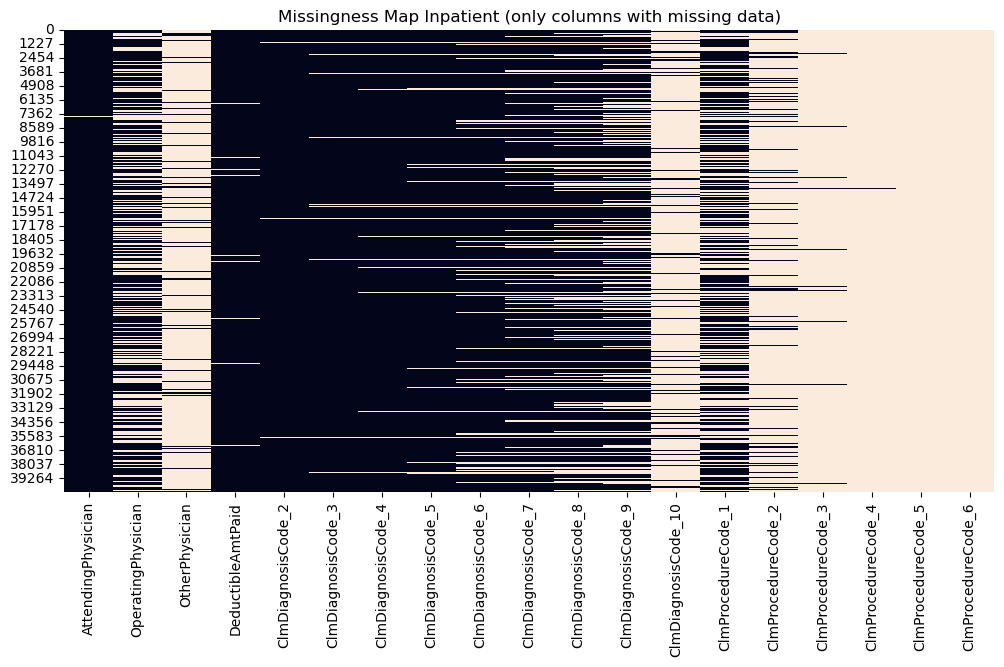

In [94]:
import seaborn as sns
import matplotlib.pyplot as plt

# Inpatient
missing_cols_in = inpatient.columns[inpatient.isnull().any()]
plt.figure(figsize=(12,6))
sns.heatmap(inpatient[missing_cols_in].isnull(), cbar=False)
plt.title("Missingness Map Inpatient (only columns with missing data)")
plt.show()




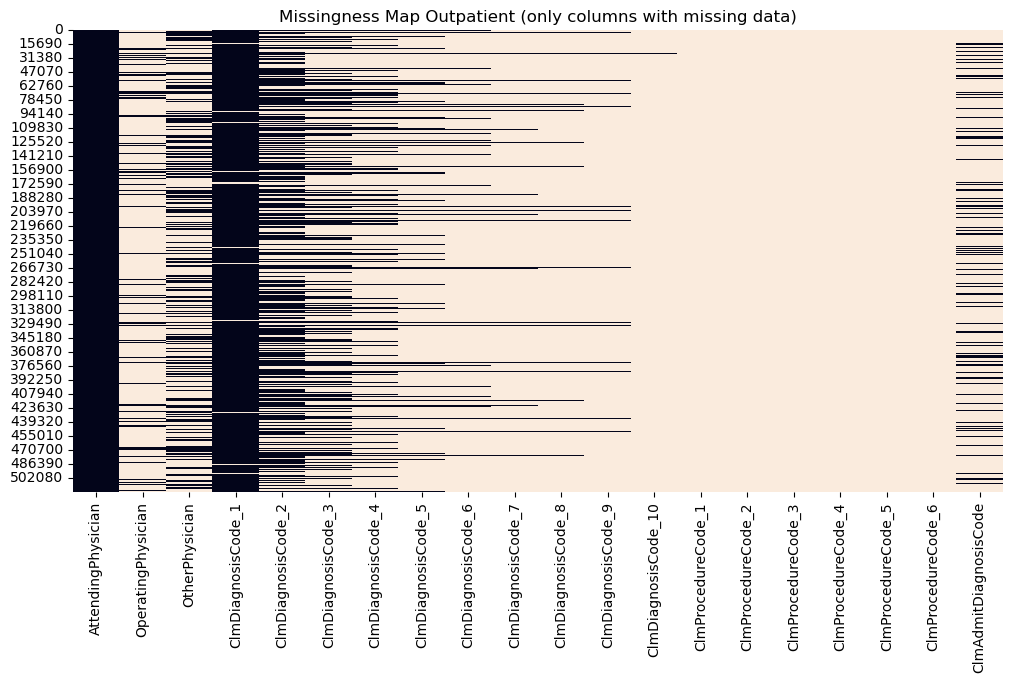

In [95]:
# Outpatient
missing_cols_out = outpatient.columns[outpatient.isnull().any()]
plt.figure(figsize=(12,6))
sns.heatmap(outpatient[missing_cols_out].isnull(), cbar=False)
plt.title("Missingness Map Outpatient (only columns with missing data)")
plt.show()

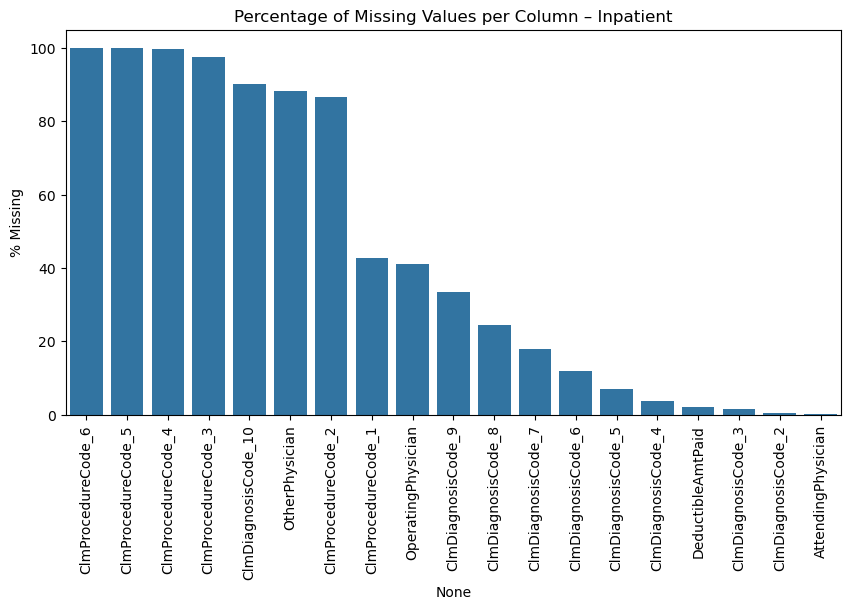

In [96]:
# Inpatient
in_missing_pct = inpatient.isnull().mean() * 100
in_missing_pct = in_missing_pct[in_missing_pct > 0].sort_values(ascending=False)

plt.figure(figsize=(10,5))
sns.barplot(x=in_missing_pct.index, y=in_missing_pct.values)
plt.xticks(rotation=90)
plt.ylabel("% Missing")
plt.title("Percentage of Missing Values per Column – Inpatient")
plt.show()

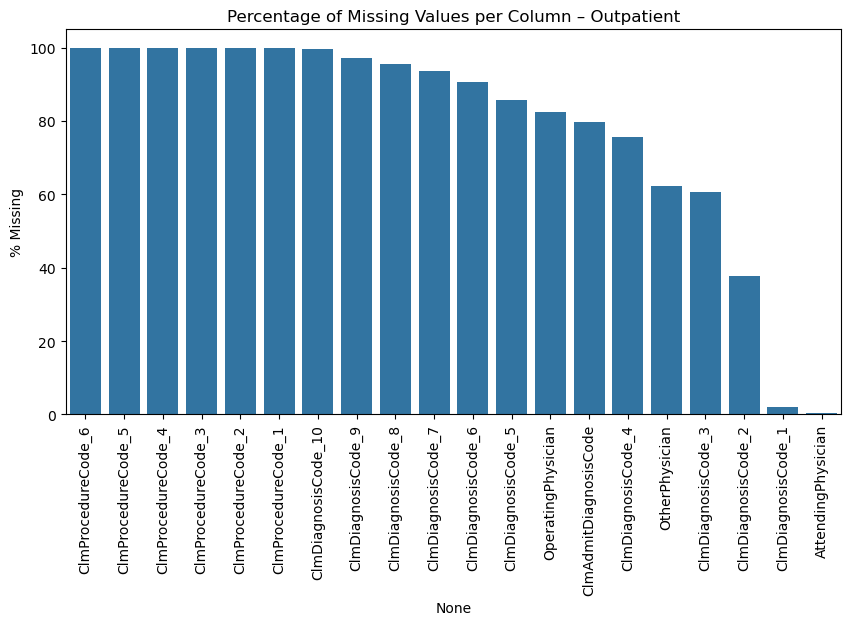

In [97]:
out_missing_pct = outpatient.isnull().mean() * 100
out_missing_pct = out_missing_pct[out_missing_pct > 0].sort_values(ascending=False)

plt.figure(figsize=(10,5))
sns.barplot(x=out_missing_pct.index, y=out_missing_pct.values)
plt.xticks(rotation=90)
plt.ylabel("% Missing")
plt.title("Percentage of Missing Values per Column – Outpatient")
plt.show()

convert to date format

In [98]:


# Beneficiary Table
benf['DOB'] = pd.to_datetime(benf['DOB'], errors='coerce')
benf['DOD'] = pd.to_datetime(benf['DOD'], errors='coerce')

#add age attribute and is alive attribute
benf['is_alive'] = benf['DOD'].isna().astype(int)
benf['age'] = ((benf['DOD'].fillna(pd.Timestamp.today()) - benf['DOB']).dt.days / 365.25).astype(int)

# Check result
benf[['DOB', 'DOD', 'is_alive', 'age']].head()

#testing:

benf_test['DOB'] = pd.to_datetime(benf_test['DOB'], errors='coerce')
benf_test['DOD'] = pd.to_datetime(benf_test['DOD'], errors='coerce')

#add age attribute and is alive attribute
benf_test['is_alive'] = benf_test['DOD'].isna().astype(int)
benf_test['age'] = ((benf_test['DOD'].fillna(pd.Timestamp.today()) - benf_test['DOB']).dt.days / 365.25).astype(int)

# Check result
benf_test[['DOB', 'DOD', 'is_alive', 'age']].head()


,DOB,DOD,is_alive,age
0,1943-01-01,NaT,1,82
1,1940-09-01,2009-12-01,0,69
2,1936-07-01,NaT,1,89
3,1914-03-01,NaT,1,111
4,1938-04-01,NaT,1,87


In [99]:

date_cols = [c for c in inpatient.columns if "Dt" in c or "Date" in c]

for col in date_cols:
    inpatient[col] = pd.to_datetime(inpatient[col], errors="coerce")
    print(col, inpatient[col].dtype)

# FORCE datetime conversion of date-like columns
date_cols = [c for c in outpatient.columns if "Dt" in c or "Date" in c]

for col in date_cols:
    outpatient[col] = pd.to_datetime(outpatient[col], errors="coerce")
    print(col, outpatient[col].dtype)


#testing:

date_cols = [c for c in inpatient_test.columns if "Dt" in c or "Date" in c]

for col in date_cols:
    inpatient_test[col] = pd.to_datetime(inpatient_test[col], errors="coerce")
    print(col, inpatient_test[col].dtype)

# FORCE datetime conversion of date-like columns
date_cols = [c for c in outpatient_test.columns if "Dt" in c or "Date" in c]

for col in date_cols:
    outpatient_test[col] = pd.to_datetime(outpatient_test[col], errors="coerce")
    print(col, outpatient_test[col].dtype)


ClaimStartDt datetime64[ns]
ClaimEndDt datetime64[ns]
AdmissionDt datetime64[ns]
DischargeDt datetime64[ns]
ClaimStartDt datetime64[ns]
ClaimEndDt datetime64[ns]
ClaimStartDt datetime64[ns]
ClaimEndDt datetime64[ns]
AdmissionDt datetime64[ns]
DischargeDt datetime64[ns]
ClaimStartDt datetime64[ns]
ClaimEndDt datetime64[ns]


### feature adding

add claim duration days feature

In [100]:


#INPATIENT
if {"ClaimStartDt", "ClaimEndDt"}.issubset(inpatient.columns):
    inpatient["claim_duration_days"] = (
        inpatient["ClaimEndDt"] - inpatient["ClaimStartDt"]
    ).dt.days
else:
    print("Missing ClaimStartDt or ClaimEndDt in inpatient")

#OUTPATIENT
if {"ClaimStartDt", "ClaimEndDt"}.issubset(outpatient.columns):
    outpatient["claim_duration_days"] = (
        outpatient["ClaimEndDt"] - outpatient["ClaimStartDt"]
    ).dt.days
else:
    print("Missing ClaimStartDt or ClaimEndDt in outpatient")

    #testing:
#INPATIENT TEST
if {"ClaimStartDt", "ClaimEndDt"}.issubset(inpatient_test.columns):
    inpatient_test["claim_duration_days"] = (
        inpatient_test["ClaimEndDt"] - inpatient_test["ClaimStartDt"]
    ).dt.days
else:
    print("Missing ClaimStartDt or ClaimEndDt in inpatient_test")

#OUTPATIENT TEST
if {"ClaimStartDt", "ClaimEndDt"}.issubset(outpatient_test.columns):
    outpatient_test["claim_duration_days"] = (
        outpatient_test["ClaimEndDt"] - outpatient_test["ClaimStartDt"]
    ).dt.days
else:
    print("Missing ClaimStartDt or ClaimEndDt in outpatient_test")



diagnosis & procedure counts

In [101]:

# INPATIENT


diag_cols_inp = [col for col in inpatient.columns if "ClmDiagnosisCode" in col]
proc_cols_inp = [col for col in inpatient.columns if "ClmProcedureCode" in col]

# count non-null, non-empty
inpatient["num_diagnoses"] = inpatient[diag_cols_inp].notna().sum(axis=1)
inpatient["num_procedures"] = inpatient[proc_cols_inp].notna().sum(axis=1)

print("Inpatient diagnosis/procedure counts created:", 
      inpatient["num_diagnoses"].head(), 
      inpatient["num_procedures"].head())


#outpatient:
diag_cols_out = [col for col in outpatient.columns if "ClmDiagnosisCode" in col]
proc_cols_out = [col for col in outpatient.columns if "ClmProcedureCode" in col]

# count non-null, non-empty
outpatient["num_diagnoses"] = outpatient[diag_cols_out].notna().sum(axis=1)
outpatient["num_procedures"] = outpatient[proc_cols_out].notna().sum(axis=1)

print("Inpatient diagnosis/procedure counts created:", 
      outpatient["num_diagnoses"].head(), 
      outpatient["num_procedures"].head())


#testing:

diag_cols_inp_test = [col for col in inpatient_test.columns if "ClmDiagnosisCode" in col]
proc_cols_inp_test = [col for col in inpatient_test.columns if "ClmProcedureCode" in col]

# count non-null, non-empty
inpatient_test["num_diagnoses"] = inpatient_test[diag_cols_inp_test].notna().sum(axis=1)
inpatient_test["num_procedures"] = inpatient_test[proc_cols_inp_test].notna().sum(axis=1)

print("Inpatient diagnosis/procedure counts created:", 
      inpatient_test["num_diagnoses"].head(), 
      inpatient_test["num_procedures"].head())

#outpatient:
diag_cols_out_test = [col for col in outpatient_test.columns if "ClmDiagnosisCode" in col]
proc_cols_out_test = [col for col in outpatient_test.columns if "ClmProcedureCode" in col]

# count non-null, non-empty
outpatient_test["num_diagnoses"] = outpatient_test[diag_cols_out_test].notna().sum(axis=1)
outpatient_test["num_procedures"] = outpatient_test[proc_cols_out_test].notna().sum(axis=1)

print("Inpatient diagnosis/procedure counts created:", 
      outpatient_test["num_diagnoses"].head(), 
      outpatient_test["num_procedures"].head())



Inpatient diagnosis/procedure counts created: 0    9
1    3
2    6
3    9
4    9
Name: num_diagnoses, dtype: int64 0    0
1    1
2    0
3    1
4    1
Name: num_procedures, dtype: int64
Inpatient diagnosis/procedure counts created: 0    3
1    1
2    1
3    1
4    6
Name: num_diagnoses, dtype: int64 0    0
1    0
2    0
3    0
4    0
Name: num_procedures, dtype: int64
Inpatient diagnosis/procedure counts created: 0    10
1     9
2     9
3    10
4     8
Name: num_diagnoses, dtype: int64 0    2
1    1
2    0
3    2
4    0
Name: num_procedures, dtype: int64
Inpatient diagnosis/procedure counts created: 0    6
1    3
2    1
3    2
4    1
Name: num_diagnoses, dtype: int64 0    0
1    0
2    0
3    0
4    0
Name: num_procedures, dtype: int64


calculating procedures per day

In [102]:
#inpatient

#procedures per day:
if "claim_duration_days" in inpatient.columns:
    inpatient["procedures_per_day"] = inpatient["num_procedures"] / (inpatient["claim_duration_days"].abs() + 1)
#test:


date_cols = inpatient_test.columns[inpatient_test.columns.str.contains('Dt|Date', case=False)]
for col in date_cols:
    inpatient_test[col] = pd.to_datetime(inpatient_test[col], errors='coerce')
inpatient_test.isnull().sum()

#procedures per day:
if "claim_duration_days" in inpatient_test.columns:
    inpatient_test["procedures_per_day"] = inpatient_test["num_procedures"] / (inpatient_test["claim_duration_days"].abs() + 1)

check if there are claim after death(adding this as a feature)

In [103]:


# Keep only BeneID + DOD for merge
ben_dod = benf[["BeneID", "DOD"]].copy()

#Inpatient
if {"BeneID", "ClaimStartDt"}.issubset(inpatient.columns):
    inpatient["ClaimStartDt"] = pd.to_datetime(inpatient["ClaimStartDt"], errors="coerce")
    inpatient = inpatient.merge(ben_dod, on="BeneID", how="left")

    # Claim after death flag
    inpatient["claim_after_death"] = (
        inpatient["DOD"].notna() &
        inpatient["ClaimStartDt"].notna() &
        (inpatient["ClaimStartDt"] > inpatient["DOD"])
    ).astype(int)

    # Days after death (positive if claim truly after death)
    inpatient["days_after_death"] = np.where(
        inpatient["DOD"].notna() & inpatient["ClaimStartDt"].notna(),
        (inpatient["ClaimStartDt"] - inpatient["DOD"]).dt.days,
        np.nan
    )


    #testing:

    #clain after death feature creation

# Keep only BeneID + DOD for merge
ben_dod_test = benf_test[["BeneID", "DOD"]].copy()

#Inpatient
if {"BeneID", "ClaimStartDt"}.issubset(inpatient_test.columns):
    inpatient_test["ClaimStartDt"] = pd.to_datetime(inpatient_test["ClaimStartDt"], errors="coerce")
    inpatient_test = inpatient_test.merge(ben_dod_test, on="BeneID", how="left")

    # Claim after death flag
    inpatient_test["claim_after_death"] = (
        inpatient_test["DOD"].notna() &
        inpatient_test["ClaimStartDt"].notna() &
        (inpatient_test["ClaimStartDt"] > inpatient_test["DOD"])
    ).astype(int)

    # Days after death (positive if claim truly after death)
    inpatient_test["days_after_death"] = np.where(
        inpatient_test["DOD"].notna() & inpatient_test["ClaimStartDt"].notna(),
        (inpatient_test["ClaimStartDt"] - inpatient_test["DOD"]).dt.days,
        np.nan
    )


   ##checking for potentially fraudulent insurance claims that were submitted AFTER a patient has already died 
    


flag claims made during periods without insurance coverage 

In [104]:
# 1) Identify coverage columns in beneficiary table
coverage_cols = [c for c in benf.columns if "NoOfMonths_Part" in c]
print("Coverage columns:", coverage_cols)

# 2) Simple binary: was EVER covered under any part (A/B/...)?
benf["has_any_coverage"] = benf[coverage_cols].sum(axis=1) > 0

# 3) Keep only BeneID + coverage flag for merging
ben_cov = benf[["BeneID", "has_any_coverage"]].copy()

# 4) Merge into INPATIENT and flag "claim during no coverage"
if "BeneID" in inpatient.columns:
    inpatient = inpatient.merge(ben_cov, on="BeneID", how="left")
    inpatient["claim_during_no_coverage"] = (
        inpatient["has_any_coverage"] == False
    ).astype(int)

# 5) Merge into OUTPATIENT and flag "claim during no coverage"
if "BeneID" in outpatient.columns:
    outpatient = outpatient.merge(ben_cov, on="BeneID", how="left")
    outpatient["claim_during_no_coverage"] = (
        outpatient["has_any_coverage"] == False
    ).astype(int)


#testing:

# 1) Identify coverage columns in beneficiary table
coverage_cols = [c for c in benf_test.columns if "NoOfMonths_Part" in c]
print("Coverage columns:", coverage_cols)

# 2) Simple binary: was EVER covered under any part (A/B/...)?
benf_test["has_any_coverage"] = benf_test[coverage_cols].sum(axis=1) > 0

# 3) Keep only BeneID + coverage flag for merging
ben_cov_test = benf_test[["BeneID", "has_any_coverage"]].copy()

# 4) Merge into INPATIENT and flag "claim during no coverage"
if "BeneID" in inpatient_test.columns:
    inpatient_test = inpatient_test.merge(ben_cov_test, on="BeneID", how="left")
    inpatient_test["claim_during_no_coverage"] = (
        inpatient_test["has_any_coverage"] == False
    ).astype(int)

# 5) Merge into OUTPATIENT and flag "claim during no coverage"
if "BeneID" in outpatient_test.columns:
    outpatient_test = outpatient_test.merge(ben_cov_test, on="BeneID", how="left")
    outpatient_test["claim_during_no_coverage"] = (
        outpatient_test["has_any_coverage"] == False
    ).astype(int)

Coverage columns: ['NoOfMonths_PartACov', 'NoOfMonths_PartBCov']
Coverage columns: ['NoOfMonths_PartACov', 'NoOfMonths_PartBCov']


encode diagnosis and procedure codes, inpatient claims

In [105]:
# List of diagnosis and procedure columns
diagnosis_cols = [f'ClmDiagnosisCode_{i}' for i in range(1, 10)]
procedure_cols = [f'ClmProcedureCode_{i}' for i in range(1, 6)]

# Encode diagnosis codes: 1 if present, 0 if null
for col in diagnosis_cols:
    inpatient[col + '_present'] = inpatient[col].notna().astype(int)

# Encode procedure codes: 1 if present, 0 if null
for col in procedure_cols:
    inpatient[col + '_present'] = inpatient[col].notna().astype(int)

# Optional: compute total diagnoses and total procedures per claim
inpatient['num_diagnoses'] = inpatient[[col + '_present' for col in diagnosis_cols]].sum(axis=1)
inpatient['num_procedures'] = inpatient[[col + '_present' for col in procedure_cols]].sum(axis=1)

# Quick check
inpatient[['num_diagnoses','num_procedures'] + [col + '_present' for col in diagnosis_cols[:3]] + [col + '_present' for col in procedure_cols[:3]]].head()



#test:


# List of diagnosis and procedure columns
diagnosis_cols = [f'ClmDiagnosisCode_{i}' for i in range(1, 10)]
procedure_cols = [f'ClmProcedureCode_{i}' for i in range(1, 6)]

# Encode diagnosis codes: 1 if present, 0 if null
for col in diagnosis_cols:
    inpatient_test[col + '_present'] = inpatient_test[col].notna().astype(int)

# Encode procedure codes: 1 if present, 0 if null
for col in procedure_cols:
    inpatient_test[col + '_present'] = inpatient_test[col].notna().astype(int)

# Optional: compute total diagnoses and total procedures per claim
inpatient_test['num_diagnoses'] = inpatient_test[[col + '_present' for col in diagnosis_cols]].sum(axis=1)
inpatient_test['num_procedures'] = inpatient_test[[col + '_present' for col in procedure_cols]].sum(axis=1)

# Quick check
inpatient_test[['num_diagnoses','num_procedures'] + [col + '_present' for col in diagnosis_cols[:3]] + [col + '_present' for col in procedure_cols[:3]]].head()




,num_diagnoses,num_procedures,ClmDiagnosisCode_1_present,ClmDiagnosisCode_2_present,ClmDiagnosisCode_3_present,ClmProcedureCode_1_present,ClmProcedureCode_2_present,ClmProcedureCode_3_present
0,9,2,1,1,1,1,1,0
1,9,1,1,1,1,1,0,0
2,9,0,1,1,1,0,0,0
3,9,2,1,1,1,1,1,0
4,8,0,1,1,1,0,0,0


In [106]:
train_labels.head(1)

,Provider,PotentialFraud
0,PRV51001,No


visualize

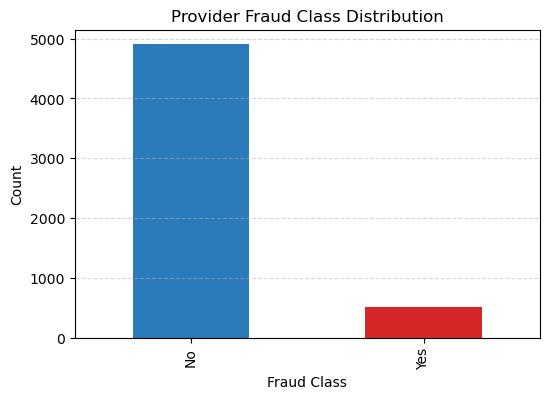

In [107]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



plt.figure(figsize=(6,4))
train_labels['PotentialFraud'].value_counts().plot(kind='bar', color=['#2b7bba','#d62728'])
plt.title("Provider Fraud Class Distribution")
plt.xlabel("Fraud Class")
plt.ylabel("Count")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


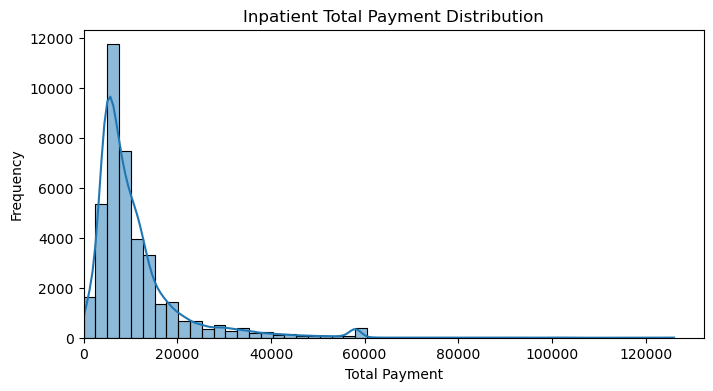

In [108]:
# Create minimal total_payment column for plotting


if {"InscClaimAmtReimbursed", "DeductibleAmtPaid"}.issubset(inpatient.columns):
    inpatient["total_payment"] = (
        inpatient["InscClaimAmtReimbursed"].fillna(0) +
        inpatient["DeductibleAmtPaid"].fillna(0)
    )

if {"InscClaimAmtReimbursed", "DeductibleAmtPaid"}.issubset(outpatient.columns):
    outpatient["total_payment"] = (
        outpatient["InscClaimAmtReimbursed"].fillna(0) +
        outpatient["DeductibleAmtPaid"].fillna(0)
    )





def plot_payment_dist(df, title):
    if "total_payment" not in df.columns:
        print(f"total_payment not found in dataframe for {title}")
        return
    
    plt.figure(figsize=(8,4))
    sns.histplot(df["total_payment"], bins=50, kde=True)
    plt.title(title)
    plt.xlabel("Total Payment")
    plt.ylabel("Frequency")
    plt.xlim(left=0)
    plt.show()

plot_payment_dist(inpatient, "Inpatient Total Payment Distribution")



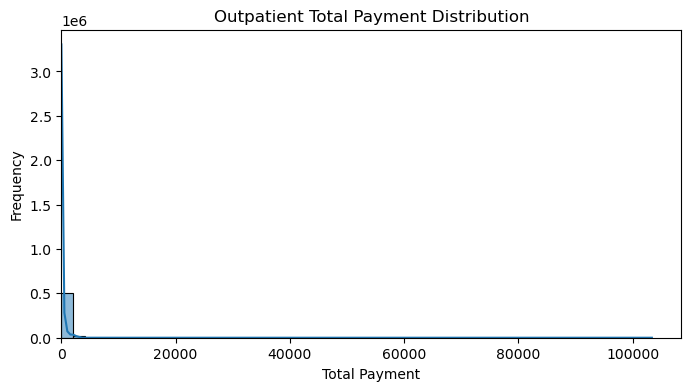

In [109]:
plot_payment_dist(outpatient, "Outpatient Total Payment Distribution")

More features:

payment flags

In [110]:

# Fill missing amounts
inpatient['DeductibleAmtPaid'] = inpatient['DeductibleAmtPaid'].fillna(0)
inpatient['InscClaimAmtReimbursed'] = inpatient['InscClaimAmtReimbursed'].fillna(0)

# Payment indicators
inpatient['patient_paid'] = (inpatient['DeductibleAmtPaid'] > 0).astype(int)
inpatient['insurer_paid'] = (inpatient['InscClaimAmtReimbursed'] > 0).astype(int)
inpatient['any_payment'] = ((inpatient['patient_paid'] == 1) | (inpatient['insurer_paid'] == 1)).astype(int)

print("Payment flags created. Sample:")
print(inpatient[['DeductibleAmtPaid','InscClaimAmtReimbursed','patient_paid','insurer_paid','any_payment']].head())


Payment flags created. Sample:
   DeductibleAmtPaid  InscClaimAmtReimbursed  patient_paid  insurer_paid  \
0             1068.0                   26000             1             1   
1             1068.0                    5000             1             1   
2             1068.0                    5000             1             1   
3             1068.0                    5000             1             1   
4             1068.0                   10000             1             1   

   any_payment  
0            1  
1            1  
2            1  
3            1  
4            1  


duration features

In [111]:

inpatient['los_days'] = (inpatient['DischargeDt'] - inpatient['AdmissionDt']).dt.days
inpatient['claim_length_days'] = (inpatient['ClaimEndDt'] - inpatient['ClaimStartDt']).dt.days

print("Duration features created. Sample:")
print(inpatient[['los_days','claim_length_days']].head())


Duration features created. Sample:
   los_days  claim_length_days
0         6                  6
1         2                  2
2         3                  3
3         8                  8
4        17                 17


BASIC DATE ANOMALY FLAGS

In [112]:
today = pd.Timestamp.today()

inpatient['ClaimStart_after_ClaimEnd'] = ((inpatient['ClaimStartDt'].notna() & inpatient['ClaimEndDt'].notna()) & 
                                         (inpatient['ClaimStartDt'] > inpatient['ClaimEndDt'])).astype(int)

inpatient['Admission_after_Discharge'] = ((inpatient['AdmissionDt'].notna() & inpatient['DischargeDt'].notna()) & 
                                          (inpatient['AdmissionDt'] > inpatient['DischargeDt'])).astype(int)

inpatient['Future_dates'] = (inpatient[['ClaimStartDt','ClaimEndDt','AdmissionDt','DischargeDt']].gt(today)
                             .any(axis=1)).astype(int)

print("Basic date anomalies flagged. Sum of anomalies:")
print(inpatient[['ClaimStart_after_ClaimEnd','Admission_after_Discharge','Future_dates']].sum())


Basic date anomalies flagged. Sum of anomalies:
ClaimStart_after_ClaimEnd    0
Admission_after_Discharge    0
Future_dates                 0
dtype: int64


potential/conditional date anomalies

In [113]:
inpatient['ClaimStart_before_Admission'] = ((inpatient['ClaimStartDt'].notna() & inpatient['AdmissionDt'].notna()) &
                                           (inpatient['ClaimStartDt'] < inpatient['AdmissionDt'])).astype(int)

inpatient['ClaimEnd_after_Discharge'] = ((inpatient['ClaimEndDt'].notna() & inpatient['DischargeDt'].notna()) &
                                         (inpatient['ClaimEndDt'] > inpatient['DischargeDt'])).astype(int)

# Conditional based on payments
inpatient['ClaimEnd_after_Discharge_no_patient_payment'] = (
    (inpatient['ClaimEnd_after_Discharge'] == 1) & (inpatient['patient_paid'] == 0)
).astype(int)

inpatient['ClaimStart_before_Admission_no_payment'] = (
    (inpatient['ClaimStart_before_Admission'] == 1) & (inpatient['any_payment'] == 0)
).astype(int)

print("Conditional anomalies flagged. Sample sums:")
print(inpatient[['ClaimEnd_after_Discharge_no_patient_payment','ClaimStart_before_Admission_no_payment']].sum())


Conditional anomalies flagged. Sample sums:
ClaimEnd_after_Discharge_no_patient_payment    0
ClaimStart_before_Admission_no_payment         0
dtype: int64


length based anomaly

In [114]:

inpatient['claim_length_vs_los_ratio'] = None
mask_valid_lengths = inpatient['claim_length_days'].notna() & inpatient['los_days'].notna() & (inpatient['los_days'] >= 0)
inpatient.loc[mask_valid_lengths, 'claim_length_vs_los_ratio'] = (
    inpatient.loc[mask_valid_lengths, 'claim_length_days'] / inpatient.loc[mask_valid_lengths, 'los_days'].replace({0: 1})
)
inpatient['claim_length_vs_los_ratio'] = inpatient['claim_length_vs_los_ratio'].astype(float)

# Flag suspicious ratio >2
inpatient['claim_length_much_greater_than_los'] = ((inpatient['claim_length_vs_los_ratio'] > 2) & mask_valid_lengths).astype(int)

print("Length-based anomalies created. Sum of flags:")
print(inpatient['claim_length_much_greater_than_los'].sum())


Length-based anomalies created. Sum of flags:
2


anomlay score/summary

In [115]:

inpatient['date_anomaly_score'] = (
      3 * inpatient['ClaimStart_after_ClaimEnd'].fillna(0)
    + 3 * inpatient['Admission_after_Discharge'].fillna(0)
    + 3 * inpatient['Future_dates'].fillna(0)
    + 2 * inpatient['ClaimEnd_after_Discharge_no_patient_payment'].fillna(0)
    + 1 * inpatient['ClaimStart_before_Admission_no_payment'].fillna(0)
    + 2 * inpatient['claim_length_much_greater_than_los'].fillna(0)
)

date_issue_cols = ['ClaimStart_after_ClaimEnd','Admission_after_Discharge','Future_dates',
                   'ClaimEnd_after_Discharge','ClaimStart_before_Admission']
inpatient['date_issue_count'] = inpatient[date_issue_cols].sum(axis=1)

print("Weighted date anomaly score & issue count created. Feature summary:")
print(inpatient[['date_anomaly_score','date_issue_count']].describe())

print("\nTop suspicious claims by score:")
print(inpatient.sort_values('date_anomaly_score', ascending=False)
      .loc[:, ['ClaimID','Provider','BeneID','date_anomaly_score','date_issue_count']].head(10))


Weighted date anomaly score & issue count created. Feature summary:
       date_anomaly_score  date_issue_count
count        40474.000000       40474.00000
mean             0.000099           0.00042
std              0.014059           0.02049
min              0.000000           0.00000
25%              0.000000           0.00000
50%              0.000000           0.00000
75%              0.000000           0.00000
max              2.000000           1.00000

Top suspicious claims by score:
        ClaimID  Provider      BeneID  date_anomaly_score  date_issue_count
21298  CLM82205  PRV52045   BENE88968                   2                 1
18267  CLM82210  PRV53461   BENE78133                   2                 1
0      CLM46614  PRV55912   BENE11001                   0                 0
26986  CLM46152  PRV53297  BENE109946                   0                 0
26979  CLM52570  PRV54889  BENE109909                   0                 0
26980  CLM79872  PRV55145  BENE109921          

This block aggregates multiple date-related anomaly features (claim dates after discharge, future dates, claim length vs. length of stay) to calculate a weighted date anomaly score for each inpatient claim. It also computes a simple count of distinct date issues and identifies the top suspicious claims based on these scores, helping flag potentially erroneous or fraudulent claims.

encoding

In [116]:
#inpatient
#1. encode physcians as either 1(present) or 0(absent) for each claim
#2. count frequency of appearance of each physcians
#3. sum number of physcians per person 


# Columns for physicians
phys_cols = ['AttendingPhysician', 'OperatingPhysician', 'OtherPhysician']

# 1️ Frequency Encoding

# Count how many times each physician ID appears across all three columns
phys_freq = pd.concat([inpatient[col] for col in phys_cols]).value_counts()

# Map the frequency back to each physician column, missing IDs get 0
for col in phys_cols:
    inpatient[col + '_freq'] = inpatient[col].map(phys_freq).fillna(0)


#2. 0/1 Presence Encoding
# Create new columns indicating presence of a physician ID
for col in phys_cols:
    inpatient[col + '_presence'] = inpatient[col].notna().astype(int)


# 3 Number of Physicians per claim

# Sum the presence columns to get total number of physicians per claim
inpatient['num_physicians'] = inpatient[[col + '_presence' for col in phys_cols]].sum(axis=1)


print(inpatient[[col + '_freq' for col in phys_cols] +
               [col + '_presence' for col in phys_cols] +
               ['num_physicians']].head())





#test:


#inpatient
#1. encode physcians as either 1(present) or 0(absent) for each claim
#2. count frequency of appearance of each physcians
#3. sum number of physcians per person 


# Columns for physicians
phys_cols = ['AttendingPhysician', 'OperatingPhysician', 'OtherPhysician']

# 1️ Frequency Encoding

# Count how many times each physician ID appears across all three columns
phys_freq = pd.concat([inpatient_test[col] for col in phys_cols]).value_counts()

# Map the frequency back to each physician column, missing IDs get 0
for col in phys_cols:
    inpatient_test[col + '_freq'] = inpatient_test[col].map(phys_freq).fillna(0)


#2. 0/1 Presence Encoding
# Create new columns indicating presence of a physician ID
for col in phys_cols:
    inpatient_test[col + '_presence'] = inpatient_test[col].notna().astype(int)


# 3 Number of Physicians per claim

# Sum the presence columns to get total number of physicians per claim
inpatient_test['num_physicians'] = inpatient_test[[col + '_presence' for col in phys_cols]].sum(axis=1)


print(inpatient_test[[col + '_freq' for col in phys_cols] +
               [col + '_presence' for col in phys_cols] +
               ['num_physicians']].head())


#Number of Physicians per Claim-> how many distinct physician roles were involved in a single claim




   AttendingPhysician_freq  OperatingPhysician_freq  OtherPhysician_freq  \
0                      1.0                      0.0                  0.0   
1                      3.0                      3.0                  0.0   
2                     12.0                      0.0                 14.0   
3                     13.0                      5.0                  7.0   
4                      2.0                      5.0                  0.0   

   AttendingPhysician_presence  OperatingPhysician_presence  \
0                            1                            0   
1                            1                            1   
2                            1                            0   
3                            1                            1   
4                            1                            1   

   OtherPhysician_presence  num_physicians  
0                        0               1  
1                        0               2  
2                        1   

## finding out what would be a normal payment per day given diagnoses on claim

ensure numeric payments and claim length

In [117]:
diag_cols = [f'ClmDiagnosisCode_{i}' for i in range(1, 11)]

# Fill missing payment amounts
inpatient['DeductibleAmtPaid'] = inpatient['DeductibleAmtPaid'].fillna(0)
inpatient['InscClaimAmtReimbursed'] = inpatient['InscClaimAmtReimbursed'].fillna(0)
inpatient['total_payment'] = inpatient['DeductibleAmtPaid'] + inpatient['InscClaimAmtReimbursed']

# Ensure claim length exists and avoid division by zero
if 'claim_length_days' not in inpatient.columns:
    inpatient['claim_length_days'] = (inpatient['ClaimEndDt'] - inpatient['ClaimStartDt']).dt.days
inpatient['claim_length_days'] = inpatient['claim_length_days'].fillna(0).astype(float)
inpatient['claim_length_days_nonzero'] = inpatient['claim_length_days'].apply(lambda x: x if x >= 1 else 1.0)

# Payment per day
inpatient['claim_payment_ppd'] = inpatient['total_payment'] / inpatient['claim_length_days_nonzero']

#test:


# diagnosis columns
diag_cols = [f'ClmDiagnosisCode_{i}' for i in range(1, 11)]

# 0. Ensure numeric payments and claim_length_days exist
inpatient_test['DeductibleAmtPaid'] = inpatient_test['DeductibleAmtPaid'].fillna(0)
inpatient_test['InscClaimAmtReimbursed'] = inpatient_test['InscClaimAmtReimbursed'].fillna(0)
inpatient_test['total_payment'] = inpatient_test['DeductibleAmtPaid'] + inpatient_test['InscClaimAmtReimbursed']

# ensure claim_length_days exists and use at least 1 day to avoid div by 0
if 'claim_length_days' not in inpatient_test.columns:
    inpatient_test['claim_length_days'] = (inpatient_test['ClaimEndDt'] - inpatient_test['ClaimStartDt']).dt.days
inpatient_test['claim_length_days'] = inpatient_test['claim_length_days'].fillna(0).astype(float)
inpatient_test['claim_length_days_nonzero'] = inpatient_test['claim_length_days'].apply(lambda x: x if x >= 1 else 1.0)

# 1. payment per day (ppd) for each claim
inpatient_test['claim_payment_ppd'] = inpatient_test['total_payment'] / inpatient_test['claim_length_days_nonzero']


transform diagnosis codes to long format so it can be used to analyze(can not be done in wide format)

In [118]:
long = inpatient[['ClaimID'] + diag_cols + ['claim_payment_ppd']].set_index('ClaimID').reset_index()

# Melt table
melted = long.melt(id_vars=['ClaimID','claim_payment_ppd'], value_vars=diag_cols,
                   var_name='diag_slot', value_name='diag_code')

# Clean diag codes: drop NaN/empty/placeholder codes
melted['diag_code'] = melted['diag_code'].astype(str).str.strip()
placeholders = {'nan', 'none', 'unknown', 'na', 'nan.', ''}
melted = melted[~melted['diag_code'].str.lower().isin(placeholders)]
melted = melted[~melted['diag_code'].isin(['nan', 'None'])]

#test:
long = (inpatient_test[['ClaimID'] + diag_cols + ['claim_payment_ppd']]
        .set_index('ClaimID')
        .reset_index())

# melt
melted_test = long.melt(id_vars=['ClaimID','claim_payment_ppd'], value_vars=diag_cols,
                   var_name='diag_slot', value_name='diag_code')

# clean diag_code: drop NaN and empty/Unknown placeholders
melted_test['diag_code'] = melted_test['diag_code'].astype(str).str.strip()
# treat common placeholders as missing
placeholders = {'nan', 'none', 'unknown', 'na', 'nan.', ''} 
melted_test = melted_test[~melted_test['diag_code'].str.lower().isin(placeholders)]
melted_test = melted_test[~melted_test['diag_code'].isin(['nan', 'None'])]

compute summary metrics per diagnosis code

In [119]:
diag_stats = (melted.groupby('diag_code')['claim_payment_ppd']
              .agg(['count', 'mean', 'median'])
              .rename(columns={'mean':'mean_ppd', 'median':'median_ppd'})
              .reset_index())

# Smooth rare diagnoses toward global median
global_mean = melted['claim_payment_ppd'].median()
k = 10.0
diag_stats['smoothed_mean_ppd'] = (
    (diag_stats['count'] * diag_stats['mean_ppd'] + k * global_mean) / 
    (diag_stats['count'] + k)
)

#test:
diag_stats_test = (melted_test.groupby('diag_code')['claim_payment_ppd']
                    .agg(['count', 'mean', 'median'])
                    .rename(columns={'mean':'mean_ppd', 'median':'median_ppd'})
                    .reset_index())

# 4. smoothing (shrink mean toward global mean) to stabilize rare codes
global_mean_test = melted_test['claim_payment_ppd'].median()  # median as robust global center
diag_stats_test['smoothed_mean_ppd'] = (diag_stats_test['count'] * diag_stats_test['mean_ppd'] + k * global_mean_test) / (diag_stats_test['count'] + k)


Map diag stats back to claim-level slots

In [120]:
smoothed_map = diag_stats.set_index('diag_code')['smoothed_mean_ppd'].to_dict()
median_map = diag_stats.set_index('diag_code')['median_ppd'].to_dict()
count_map = diag_stats.set_index('diag_code')['count'].to_dict()

for col in diag_cols:
    inpatient[col + '_diag_exp_ppd'] = inpatient[col].map(smoothed_map).fillna(0.0)
    inpatient[col + '_diag_median_ppd'] = inpatient[col].map(median_map).fillna(0.0)
    inpatient[col + '_diag_count'] = inpatient[col].map(count_map).fillna(0).astype(int)

#testing: 
smoothed_map_test = diag_stats_test.set_index('diag_code')['smoothed_mean_ppd'].to_dict()
median_map_test = diag_stats_test.set_index('diag_code')['median_ppd'].to_dict()
count_map_test = diag_stats_test.set_index('diag_code')['count'].to_dict()

# For each diag slot, create mapped expected_ppd, median_ppd, count
for col in diag_cols:
    inpatient_test[col + '_diag_exp_ppd'] = inpatient_test[col].map(smoothed_map_test).fillna(0.0)
    inpatient_test[col + '_diag_median_ppd'] = inpatient_test[col].map(median_map_test).fillna(0.0)
    inpatient_test[col + '_diag_count'] = inpatient_test[col].map(count_map_test).fillna(0).astype(int)


Compute claim-level aggregated diagnosis expectations

In [121]:
exp_cols = [c + '_diag_exp_ppd' for c in diag_cols]
med_cols = [c + '_diag_median_ppd' for c in diag_cols]
cnt_cols = [c + '_diag_count' for c in diag_cols]

inpatient['diag_expected_mean_ppd'] = inpatient[exp_cols].replace(0, np.nan).mean(axis=1).fillna(0.0)
inpatient['diag_expected_median_ppd'] = inpatient[med_cols].replace(0, np.nan).median(axis=1).fillna(0.0)
inpatient['diag_expected_max_ppd'] = inpatient[exp_cols].max(axis=1).fillna(0.0)
inpatient['diag_expected_sum_ppd'] = inpatient[exp_cols].sum(axis=1).fillna(0.0)
inpatient['diag_present_count'] = (inpatient[exp_cols] > 0).sum(axis=1)

#testing
exp_cols = [c + '_diag_exp_ppd' for c in diag_cols]
med_cols = [c + '_diag_median_ppd' for c in diag_cols]
cnt_cols = [c + '_diag_count' for c in diag_cols]

# mean expected ppd across present diagnosis codes (ignore zeros)
inpatient_test['diag_expected_mean_ppd'] = inpatient_test[exp_cols].replace(0, np.nan).mean(axis=1).fillna(0.0)
inpatient_test['diag_expected_median_ppd'] = inpatient_test[med_cols].replace(0, np.nan).median(axis=1).fillna(0.0)
inpatient_test['diag_expected_max_ppd'] = inpatient_test[exp_cols].max(axis=1).fillna(0.0)
inpatient_test['diag_expected_sum_ppd'] = inpatient_test[exp_cols].sum(axis=1).fillna(0.0)
inpatient_test['diag_present_count'] = (inpatient_test[exp_cols] > 0).sum(axis=1)

 Ratio features: actual vs expected

In [122]:
inpatient['claim_ppd_to_diag_expected_mean'] = np.where(
    inpatient['diag_expected_mean_ppd'] > 0,
    inpatient['claim_payment_ppd'] / inpatient['diag_expected_mean_ppd'],
    np.nan
)
inpatient['claim_ppd_to_diag_expected_max'] = np.where(
    inpatient['diag_expected_max_ppd'] > 0,
    inpatient['claim_payment_ppd'] / inpatient['diag_expected_max_ppd'],
    np.nan
)
inpatient['expected_vs_actual_gap_ppd'] = inpatient['claim_payment_ppd'] - inpatient['diag_expected_mean_ppd']
inpatient['expected_vs_actual_pct_ppd'] = inpatient['claim_payment_ppd'] / inpatient['diag_expected_mean_ppd'].replace({0: np.nan})

#testing:
inpatient_test['claim_ppd_to_diag_expected_mean'] = np.where(
    inpatient_test['diag_expected_mean_ppd'] > 0,
    inpatient_test['claim_payment_ppd'] / inpatient_test['diag_expected_mean_ppd'],
    np.nan
)

inpatient_test['claim_ppd_to_diag_expected_max'] = np.where(
    inpatient_test['diag_expected_max_ppd'] > 0,
    inpatient_test['claim_payment_ppd'] / inpatient_test['diag_expected_max_ppd'],
    np.nan
)
inpatient_test['expected_vs_actual_gap_ppd'] = inpatient_test['claim_payment_ppd'] - inpatient_test['diag_expected_mean_ppd']
inpatient_test['expected_vs_actual_pct_ppd'] = inpatient_test['claim_payment_ppd'] / inpatient_test['diag_expected_mean_ppd'].replace({0: np.nan})

Flag claims with rare diagnoses


In [123]:
rare_threshold = 5
inpatient['claim_has_rare_diag'] = (inpatient[cnt_cols] > 0).apply(lambda row: any(row < rare_threshold), axis=1).astype(int)
#testing:
rare_threshold = 5
inpatient_test['claim_has_rare_diag'] = (inpatient_test[cnt_cols] > 0).apply(lambda row: any(row < rare_threshold), axis=1).astype(int)

Final features and summary

In [128]:
final_diag_features = [
    'diag_expected_mean_ppd', 'diag_expected_median_ppd', 'diag_expected_max_ppd',
    'diag_expected_sum_ppd', 'diag_present_count', 'claim_ppd_to_diag_expected_mean',
    'claim_ppd_to_diag_expected_max', 'claim_has_rare_diag', 'expected_vs_actual_gap_ppd',
    'expected_vs_actual_pct_ppd'
]

print("Diagnosis-payment feature creation complete.")
print("Number of unique diagnosis codes modeled:", len(diag_stats))
print(diag_stats[['diag_code','count','median_ppd','smoothed_mean_ppd']].sort_values('count', ascending=False).head(10))

Diagnosis-payment feature creation complete.
Number of unique diagnosis codes modeled: 4716
     diag_code  count   median_ppd  smoothed_mean_ppd
1492      4019  14153  2034.000000        3203.402652
675       2724   7340  2213.600000        3385.299980
571      25000   7334  2034.000000        3156.062533
1549     41401   6442  2356.000000        3691.395932
1626      4280   6190  2022.666667        2994.176135
1615     42731   6070  2034.000000        3170.949817
2384      5990   5390  1883.500000        2781.356162
2046     53081   4912  2034.000000        3149.793897
558       2449   4205  2022.666667        3028.526964
2322      5849   4082  2017.000000        3098.306526


In [129]:
#testing:
final_diag_features = [
    'diag_expected_mean_ppd', 'diag_expected_median_ppd', 'diag_expected_max_ppd',
    'diag_expected_sum_ppd', 'diag_present_count', 'claim_ppd_to_diag_expected_mean',
    'claim_ppd_to_diag_expected_max', 'claim_has_rare_diag', 'expected_vs_actual_gap_ppd',
    'expected_vs_actual_pct_ppd'
]

print("Diagnosis-payment feature creation complete.")
print("Number of unique diagnosis codes modeled:", len(diag_stats_test))
print(diag_stats_test[['diag_code','count','median_ppd','smoothed_mean_ppd']].sort_values('count', ascending=False).head(10))

Diagnosis-payment feature creation complete.
Number of unique diagnosis codes modeled: 3216
     diag_code  count   median_ppd  smoothed_mean_ppd
1006      4019   3316  2034.000000        3211.427331
438       2724   1758  2034.000000        3335.033014
362      25000   1694  2034.000000        3357.383339
1123      4280   1465  2017.000000        3219.390138
1053     41401   1455  2356.000000        3779.672388
1112     42731   1428  2022.666667        3148.117695
1712      5990   1220  1767.000000        2766.165089
1444     53081   1141  2034.000000        3180.892677
1371       496    977  2034.000000        3288.837226
1661      5849    952  2022.666667        3105.557371


#### outpatient dataset

same implementation that was done to inpatient

In [130]:
###outpatient
#1) Parse date columns (safe)
date_cols = outpatient.columns[outpatient.columns.str.contains('Dt|Date', case=False)]
for col in date_cols:
    outpatient[col] = pd.to_datetime(outpatient[col], errors='coerce')

today = pd.Timestamp.today()

#number of procedures per day
if "claim_duration_days" in outpatient.columns:
    outpatient["procedures_per_day"] = outpatient["num_procedures"] / (outpatient["claim_duration_days"].abs() + 1)

#checking for potentially fraudulent insurance claims that were submitted AFTER a patient has already died 
if {"BeneID", "ClaimStartDt"}.issubset(outpatient.columns):
    outpatient["ClaimStartDt"] = pd.to_datetime(outpatient["ClaimStartDt"], errors="coerce")
    outpatient = outpatient.merge(ben_dod, on="BeneID", how="left")

    outpatient["claim_after_death"] = (
        outpatient["DOD"].notna() &
        outpatient["ClaimStartDt"].notna() &
        (outpatient["ClaimStartDt"] > outpatient["DOD"])
    ).astype(int)

    outpatient["days_after_death"] = np.where(
        outpatient["DOD"].notna() & outpatient["ClaimStartDt"].notna(),
        (outpatient["ClaimStartDt"] - outpatient["DOD"]).dt.days,
        np.nan
    )

# 2) Diagnosis / Procedure presence flags & counts
diag_cols = [f'ClmDiagnosisCode_{i}' for i in range(1, 11)]
procedure_cols = [f'ClmProcedureCode_{i}' for i in range(1, 7)]

# presence flags (1 if present, 0 if null/empty/placeholder)
placeholders = {'nan', 'none', 'unknown', 'na', '', 'nan.'}
for col in diag_cols:
    outpatient[col] = outpatient[col].astype(str).str.strip().replace({c: np.nan for c in placeholders})
    outpatient[col + '_present'] = outpatient[col].notna().astype(int)

for col in procedure_cols:
    outpatient[col] = outpatient[col].astype(str).str.strip().replace({c: np.nan for c in placeholders})
    outpatient[col + '_present'] = outpatient[col].notna().astype(int)

# totals per claim
outpatient['num_diagnoses'] = outpatient[[c + '_present' for c in diag_cols]].sum(axis=1)
outpatient['num_procedures'] = outpatient[[c + '_present' for c in procedure_cols]].sum(axis=1)

# 3) Safe numeric payments
outpatient['DeductibleAmtPaid'] = outpatient['DeductibleAmtPaid'].fillna(0).astype(float)
outpatient['InscClaimAmtReimbursed'] = outpatient['InscClaimAmtReimbursed'].fillna(0).astype(float)
outpatient['total_payment'] = outpatient['DeductibleAmtPaid'] + outpatient['InscClaimAmtReimbursed']

# payment flags
outpatient['patient_paid'] = (outpatient['DeductibleAmtPaid'] > 0).astype(int)
outpatient['insurer_paid'] = (outpatient['InscClaimAmtReimbursed'] > 0).astype(int)
outpatient['any_payment'] = ((outpatient['patient_paid'] == 1) | (outpatient['insurer_paid'] == 1)).astype(int)

# 4) Duration feature (days) — usually 0 for outpatient but keep it
outpatient['claim_duration_days'] = (outpatient['ClaimEndDt'] - outpatient['ClaimStartDt']).dt.days
# keep NaNs if dates missing; also a nonzero-safe version for division when needed
outpatient['claim_duration_days_nonzero'] = outpatient['claim_duration_days'].apply(lambda x: x if (pd.notna(x) and x >= 1) else 1.0)

# 5) Date anomalies relevant to outpatient
outpatient['ClaimStart_after_ClaimEnd'] = ((outpatient['ClaimStartDt'].notna() & outpatient['ClaimEndDt'].notna()) &
                                           (outpatient['ClaimStartDt'] > outpatient['ClaimEndDt'])).astype(int)

outpatient['ClaimStart_before_ClaimEnd'] = ((outpatient['ClaimStartDt'].notna() & outpatient['ClaimEndDt'].notna()) &
                                            (outpatient['ClaimStartDt'] < outpatient['ClaimEndDt'])).astype(int)  # mostly true

outpatient['Future_dates'] = (outpatient[['ClaimStartDt','ClaimEndDt']].gt(today).any(axis=1)).astype(int)

outpatient['ClaimStart_before_Now_but_End_missing'] = ((outpatient['ClaimStartDt'].notna() & outpatient['ClaimEndDt'].isna())).astype(int)

# conditional suspicious flags:
outpatient['ClaimStart_after_ClaimEnd_no_payment'] = ((outpatient['ClaimStart_after_ClaimEnd'] == 1) & (outpatient['any_payment'] == 0)).astype(int)
outpatient['Future_dates_no_payment'] = ((outpatient['Future_dates'] == 1) & (outpatient['any_payment'] == 0)).astype(int)

# 6) Physician features (same logic as inpatient)
phys_cols = ['AttendingPhysician', 'OperatingPhysician', 'OtherPhysician']

# freq encoding across all physician columns
phys_freq = pd.concat([outpatient[col] for col in phys_cols]).value_counts()
for col in phys_cols:
    outpatient[col + '_freq'] = outpatient[col].map(phys_freq).fillna(0).astype(int)
    outpatient[col + '_presence'] = outpatient[col].notna().astype(int)

outpatient['num_physicians'] = outpatient[[col + '_presence' for col in phys_cols]].sum(axis=1)

# 7) Diagnosis-level expected-payment modeling (smoothed)
# We'll map diag -> smoothed mean of total_payment for claims containing that diag.
# Build a long table of ClaimID, diag_code, claim_payment
long = outpatient[['ClaimID'] + diag_cols + ['total_payment']].set_index('ClaimID').reset_index()
melted = long.melt(id_vars=['ClaimID','total_payment'], value_vars=diag_cols,
                   var_name='diag_slot', value_name='diag_code')
# clean diag_code
melted['diag_code'] = melted['diag_code'].astype(str).str.strip()
melted = melted[~melted['diag_code'].str.lower().isin(placeholders)]
melted = melted[melted['diag_code'].notna()]

# compute diag-level stats
diag_stats = (melted.groupby('diag_code')['total_payment']
                    .agg(['count', 'mean', 'median'])
                    .rename(columns={'mean':'mean_payment', 'median':'median_payment'})
                    .reset_index())

# smoothing toward global median to stabilise rare codes
global_center = melted['total_payment'].median() if len(melted)>0 else 0.0
k = 10.0  # prior strength; tuneable
diag_stats['smoothed_mean_payment'] = (diag_stats['count'] * diag_stats['mean_payment'] + k * global_center) / (diag_stats['count'] + k)

# mapping dicts
smoothed_map = diag_stats.set_index('diag_code')['smoothed_mean_payment'].to_dict()
median_map = diag_stats.set_index('diag_code')['median_payment'].to_dict()
count_map = diag_stats.set_index('diag_code')['count'].to_dict()

# map back to outpatient per diag slot
for col in diag_cols:
    outpatient[col + '_diag_exp_payment'] = outpatient[col].map(smoothed_map).fillna(0.0)
    outpatient[col + '_diag_median_payment'] = outpatient[col].map(median_map).fillna(0.0)
    outpatient[col + '_diag_count'] = outpatient[col].map(count_map).fillna(0).astype(int)

# aggregate diag-derived expectations at claim-level
exp_cols = [c + '_diag_exp_payment' for c in diag_cols]
med_cols = [c + '_diag_median_payment' for c in diag_cols]
cnt_cols = [c + '_diag_count' for c in diag_cols]

outpatient['diag_expected_mean_payment'] = outpatient[exp_cols].replace(0, np.nan).mean(axis=1).fillna(0.0)
outpatient['diag_expected_median_payment'] = outpatient[med_cols].replace(0, np.nan).median(axis=1).fillna(0.0)
outpatient['diag_expected_max_payment'] = outpatient[exp_cols].max(axis=1).fillna(0.0)
outpatient['diag_expected_sum_payment'] = outpatient[exp_cols].sum(axis=1).fillna(0.0)
outpatient['diag_present_count'] = (outpatient[exp_cols] > 0).sum(axis=1)

# ratio features: actual total_payment vs expected
outpatient['claim_to_diag_expected_mean'] = np.where(
    outpatient['diag_expected_mean_payment'] > 0,
    outpatient['total_payment'] / outpatient['diag_expected_mean_payment'],
    np.nan
)

outpatient['claim_to_diag_expected_max'] = np.where(
    outpatient['diag_expected_max_payment'] > 0,
    outpatient['total_payment'] / outpatient['diag_expected_max_payment'],
    np.nan
)

# rare-diagnosis flag
rare_threshold = 5
outpatient['claim_has_rare_diag'] = (outpatient[cnt_cols] > 0).apply(lambda row: any(row < rare_threshold), axis=1).astype(int)

# expected vs actual gaps
outpatient['expected_vs_actual_gap'] = outpatient['total_payment'] - outpatient['diag_expected_mean_payment']
outpatient['expected_vs_actual_pct'] = outpatient['total_payment'] / outpatient['diag_expected_mean_payment'].replace({0: np.nan})

# 8) Summaries & quick checks
print("Outpatient date/anomaly summary:")
date_issue_cols = ['ClaimStart_after_ClaimEnd','Future_dates','ClaimStart_before_ClaimEnd','ClaimStart_after_ClaimEnd_no_payment','Future_dates_no_payment']
print(outpatient[date_issue_cols].sum())

print("\nTop suspicious outpatient claims by expected_vs_actual_gap:")
print(outpatient.sort_values('expected_vs_actual_gap', ascending=False)
                .loc[:, ['ClaimID','Provider','BeneID','total_payment','diag_expected_mean_payment','expected_vs_actual_gap','claim_to_diag_expected_mean']]
                .head(20))





#test:



### outpatient_test
# 1) Parse date columns (safe)
date_cols = outpatient_test.columns[outpatient_test.columns.str.contains('Dt|Date', case=False)]
for col in date_cols:
    outpatient_test[col] = pd.to_datetime(outpatient_test[col], errors='coerce')

today = pd.Timestamp.today()

#number of procedures per day
if "claim_duration_days" in outpatient_test.columns:
    outpatient_test["procedures_per_day"] = outpatient_test["num_procedures"] / (outpatient_test["claim_duration_days"].abs() + 1)

#checking for potentially fraudulent insurance claims that were submitted AFTER a patient has already died 
if {"BeneID", "ClaimStartDt"}.issubset(outpatient_test.columns):
    outpatient_test["ClaimStartDt"] = pd.to_datetime(outpatient_test["ClaimStartDt"], errors="coerce")
    outpatient_test = outpatient_test.merge(ben_dod, on="BeneID", how="left")

    outpatient_test["claim_after_death"] = (
        outpatient_test["DOD"].notna() &
        outpatient_test["ClaimStartDt"].notna() &
        (outpatient_test["ClaimStartDt"] > outpatient_test["DOD"])
    ).astype(int)

    outpatient_test["days_after_death"] = np.where(
        outpatient_test["DOD"].notna() & outpatient_test["ClaimStartDt"].notna(),
        (outpatient_test["ClaimStartDt"] - outpatient_test["DOD"]).dt.days,
        np.nan
    )

# 2) Diagnosis / Procedure presence flags & counts
diag_cols = [f'ClmDiagnosisCode_{i}' for i in range(1, 11)]
procedure_cols = [f'ClmProcedureCode_{i}' for i in range(1, 7)]

# presence flags (1 if present, 0 if null/empty/placeholder)
placeholders = {'nan', 'none', 'unknown', 'na', '', 'nan.'}
for col in diag_cols:
    outpatient_test[col] = outpatient_test[col].astype(str).str.strip().replace({c: np.nan for c in placeholders})
    outpatient_test[col + '_present'] = outpatient_test[col].notna().astype(int)

for col in procedure_cols:
    outpatient_test[col] = outpatient_test[col].astype(str).str.strip().replace({c: np.nan for c in placeholders})
    outpatient_test[col + '_present'] = outpatient_test[col].notna().astype(int)

# totals per claim
outpatient_test['num_diagnoses'] = outpatient_test[[c + '_present' for c in diag_cols]].sum(axis=1)
outpatient_test['num_procedures'] = outpatient_test[[c + '_present' for c in procedure_cols]].sum(axis=1)

# 3) Safe numeric payments
outpatient_test['DeductibleAmtPaid'] = outpatient_test['DeductibleAmtPaid'].fillna(0).astype(float)
outpatient_test['InscClaimAmtReimbursed'] = outpatient_test['InscClaimAmtReimbursed'].fillna(0).astype(float)
outpatient_test['total_payment'] = outpatient_test['DeductibleAmtPaid'] + outpatient_test['InscClaimAmtReimbursed']

# payment flags
outpatient_test['patient_paid'] = (outpatient_test['DeductibleAmtPaid'] > 0).astype(int)
outpatient_test['insurer_paid'] = (outpatient_test['InscClaimAmtReimbursed'] > 0).astype(int)
outpatient_test['any_payment'] = ((outpatient_test['patient_paid'] == 1) | (outpatient_test['insurer_paid'] == 1)).astype(int)

# 4) Duration feature (days)
outpatient_test['claim_duration_days'] = (outpatient_test['ClaimEndDt'] - outpatient_test['ClaimStartDt']).dt.days
outpatient_test['claim_duration_days_nonzero'] = outpatient_test['claim_duration_days'].apply(lambda x: x if (pd.notna(x) and x >= 1) else 1.0)

# 5) Date anomalies relevant to outpatient_test
outpatient_test['ClaimStart_after_ClaimEnd'] = ((outpatient_test['ClaimStartDt'].notna() & outpatient_test['ClaimEndDt'].notna()) &
                                           (outpatient_test['ClaimStartDt'] > outpatient_test['ClaimEndDt'])).astype(int)

outpatient_test['ClaimStart_before_ClaimEnd'] = ((outpatient_test['ClaimStartDt'].notna() & outpatient_test['ClaimEndDt'].notna()) &
                                            (outpatient_test['ClaimStartDt'] < outpatient_test['ClaimEndDt'])).astype(int)

outpatient_test['Future_dates'] = (outpatient_test[['ClaimStartDt','ClaimEndDt']].gt(today).any(axis=1)).astype(int)

outpatient_test['ClaimStart_before_Now_but_End_missing'] = ((outpatient_test['ClaimStartDt'].notna() & outpatient_test['ClaimEndDt'].isna())).astype(int)

# conditional suspicious flags:
outpatient_test['ClaimStart_after_ClaimEnd_no_payment'] = ((outpatient_test['ClaimStart_after_ClaimEnd'] == 1) & (outpatient_test['any_payment'] == 0)).astype(int)
outpatient_test['Future_dates_no_payment'] = ((outpatient_test['Future_dates'] == 1) & (outpatient_test['any_payment'] == 0)).astype(int)

# 6) Physician features
phys_cols = ['AttendingPhysician', 'OperatingPhysician', 'OtherPhysician']

# freq encoding
phys_freq = pd.concat([outpatient_test[col] for col in phys_cols]).value_counts()
for col in phys_cols:
    outpatient_test[col + '_freq'] = outpatient_test[col].map(phys_freq).fillna(0).astype(int)
    outpatient_test[col + '_presence'] = outpatient_test[col].notna().astype(int)

outpatient_test['num_physicians'] = outpatient_test[[col + '_presence' for col in phys_cols]].sum(axis=1)

# 7) Diagnosis-level modeling
long = outpatient_test[['ClaimID'] + diag_cols + ['total_payment']].set_index('ClaimID').reset_index()
melted = long.melt(id_vars=['ClaimID','total_payment'], value_vars=diag_cols,
                   var_name='diag_slot', value_name='diag_code')

melted['diag_code'] = melted['diag_code'].astype(str).str.strip()
melted = melted[~melted['diag_code'].str.lower().isin(placeholders)]
melted = melted[melted['diag_code'].notna()]

diag_stats = (melted.groupby('diag_code')['total_payment']
                    .agg(['count', 'mean', 'median'])
                    .rename(columns={'mean':'mean_payment', 'median':'median_payment'})
                    .reset_index())

global_center = melted['total_payment'].median() if len(melted)>0 else 0.0
k = 10.0
diag_stats['smoothed_mean_payment'] = (diag_stats['count'] * diag_stats['mean_payment'] + k * global_center) / (diag_stats['count'] + k)

smoothed_map = diag_stats.set_index('diag_code')['smoothed_mean_payment'].to_dict()
median_map = diag_stats.set_index('diag_code')['median_payment'].to_dict()
count_map = diag_stats.set_index('diag_code')['count'].to_dict()

for col in diag_cols:
    outpatient_test[col + '_diag_exp_payment'] = outpatient_test[col].map(smoothed_map).fillna(0.0)
    outpatient_test[col + '_diag_median_payment'] = outpatient_test[col].map(median_map).fillna(0.0)
    outpatient_test[col + '_diag_count'] = outpatient_test[col].map(count_map).fillna(0).astype(int)

# aggregate
exp_cols = [c + '_diag_exp_payment' for c in diag_cols]
med_cols = [c + '_diag_median_payment' for c in diag_cols]
cnt_cols = [c + '_diag_count' for c in diag_cols]

outpatient_test['diag_expected_mean_payment'] = outpatient_test[exp_cols].replace(0, np.nan).mean(axis=1).fillna(0.0)
outpatient_test['diag_expected_median_payment'] = outpatient_test[med_cols].replace(0, np.nan).median(axis=1).fillna(0.0)
outpatient_test['diag_expected_max_payment'] = outpatient_test[exp_cols].max(axis=1).fillna(0.0)
outpatient_test['diag_expected_sum_payment'] = outpatient_test[exp_cols].sum(axis=1).fillna(0.0)
outpatient_test['diag_present_count'] = (outpatient_test[exp_cols] > 0).sum(axis=1)

outpatient_test['claim_to_diag_expected_mean'] = np.where(
    outpatient_test['diag_expected_mean_payment'] > 0,
    outpatient_test['total_payment'] / outpatient_test['diag_expected_mean_payment'],
    np.nan
)

outpatient_test['claim_to_diag_expected_max'] = np.where(
    outpatient_test['diag_expected_max_payment'] > 0,
    outpatient_test['total_payment'] / outpatient_test['diag_expected_max_payment'],
    np.nan
)

rare_threshold = 5
outpatient_test['claim_has_rare_diag'] = (outpatient_test[cnt_cols] > 0).apply(lambda row: any(row < rare_threshold), axis=1).astype(int)

outpatient_test['expected_vs_actual_gap'] = outpatient_test['total_payment'] - outpatient_test['diag_expected_mean_payment']
outpatient_test['expected_vs_actual_pct'] = outpatient_test['total_payment'] / outpatient_test['diag_expected_mean_payment'].replace({0: np.nan})

# 8) Summaries
print("Outpatient_test date/anomaly summary:")
date_issue_cols = ['ClaimStart_after_ClaimEnd','Future_dates','ClaimStart_before_ClaimEnd','ClaimStart_after_ClaimEnd_no_payment','Future_dates_no_payment']
print(outpatient_test[date_issue_cols].sum())

print("\nTop suspicious outpatient_test claims by expected_vs_actual_gap:")
print(outpatient_test.sort_values('expected_vs_actual_gap', ascending=False)
                .loc[:, ['ClaimID','Provider','BeneID','total_payment','diag_expected_mean_payment','expected_vs_actual_gap','claim_to_diag_expected_mean']]
                .head(20))



C:\Users\User\AppData\Local\Temp\ipykernel_25672\3269818322.py:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  outpatient[col] = outpatient[col].astype(str).str.strip().replace({c: np.nan for c in placeholders})
C:\Users\User\AppData\Local\Temp\ipykernel_25672\3269818322.py:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  outpatient[col] = outpatient[col].astype(str).str.strip().replace({c: np.nan for c in placeholders})
C:\Users\User\AppData\Local\Temp\ipykernel_25672\3269818322.py:140: PerformanceWarning: DataFrame is highly 

Outpatient date/anomaly summary:
ClaimStart_after_ClaimEnd                   0
Future_dates                                0
ClaimStart_before_ClaimEnd              64389
ClaimStart_after_ClaimEnd_no_payment        0
Future_dates_no_payment                     0
dtype: int64

Top suspicious outpatient claims by expected_vs_actual_gap:
          ClaimID  Provider      BeneID  total_payment  \
9326     CLM82013  PRV55172   BENE13669       103376.0   
505756   CLM82010  PRV53461  BENE155688       102115.0   
349263   CLM82006  PRV51119  BENE111157        96445.0   
232849   CLM82012  PRV53114   BENE77765        86577.0   
341672   CLM82011  PRV55205  BENE108968        85546.0   
50435    CLM82009  PRV51399   BENE25318        85336.0   
418824   CLM82014  PRV56507  BENE130861        84057.0   
227767  CLM701874  PRV51391   BENE76346        17300.0   
317240  CLM522811  PRV52631  BENE101955        17300.0   
165974  CLM745499  PRV57518   BENE58720        17300.0   
237553  CLM697027  PRV560

C:\Users\User\AppData\Local\Temp\ipykernel_25672\3269818322.py:212: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  outpatient_test[col] = outpatient_test[col].astype(str).str.strip().replace({c: np.nan for c in placeholders})
C:\Users\User\AppData\Local\Temp\ipykernel_25672\3269818322.py:212: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  outpatient_test[col] = outpatient_test[col].astype(str).str.strip().replace({c: np.nan for c in placeholders})
C:\Users\User\AppData\Local\Temp\ipykernel_25672\3269818322.py:212: FutureWarning: Dow

Outpatient_test date/anomaly summary:
ClaimStart_after_ClaimEnd                   0
Future_dates                                0
ClaimStart_before_ClaimEnd              15597
ClaimStart_after_ClaimEnd_no_payment        0
Future_dates_no_payment                     0
dtype: int64

Top suspicious outpatient_test claims by expected_vs_actual_gap:
          ClaimID  Provider      BeneID  total_payment  \
115251   CLM82007  PRV54766  BENE146654        94137.0   
18072    CLM82005  PRV51407   BENE32122        82454.0   
99275    CLM82008  PRV54980  BENE127888        81654.0   
3523    CLM482088  PRV55199   BENE15135        17300.0   
124553  CLM120856  PRV51069  BENE157647        17300.0   
99798    CLM82309  PRV53286  BENE128584        17300.0   
99793   CLM462389  PRV53286  BENE128584        17300.0   
6787    CLM621100  PRV55889   BENE18828        16600.0   
106958  CLM425937  PRV51085  BENE136813        16700.0   
52229   CLM739959  PRV55222   BENE72200        15500.0   
119354  CLM1731

SAME-DAY MULTIPLE CLAIMS (BENEFICIARY-PROVIDER)

In [ ]:

def add_same_day_claim_flags(df, label):
    required = {"BeneID", "Provider", "ClaimStartDt"}
    if not required.issubset(df.columns):
        print(f"[{label}] Missing columns for same-day flags, skipping")
        return df

    # Ensure ClaimStartDt is datetime
    df["ClaimStartDt"] = pd.to_datetime(df["ClaimStartDt"], errors="coerce")

    # Count claims per BeneID-Provider-Date
    counts = (
        df.groupby(["BeneID", "Provider", "ClaimStartDt"])
        .size()
        .reset_index(name="same_day_claims_count")
    )

    # Merge counts back
    df = df.merge(counts, on=["BeneID", "Provider", "ClaimStartDt"], how="left")

    # Flag multiple claims on same day
    df["same_day_multiple_claims_flag"] = (df["same_day_claims_count"] > 1).astype(int)

    # Drop temporary count column
    df.drop(columns=["same_day_claims_count"], inplace=True)

    return df

inpatient = add_same_day_claim_flags(inpatient, "INPATIENT")
outpatient = add_same_day_claim_flags(outpatient, "OUTPATIENT")
inpatient_test = add_same_day_claim_flags(inpatient_test, "INPATIENT_TEST")
outpatient_test = add_same_day_claim_flags(outpatient_test, "OUTPATIENT_TEST")


VISITS PER BENEFICIARY-PROVIDER/Unnecessary treatments

In [ ]:

def add_visits_per_bene_provider(df, label):
    required = {"BeneID", "Provider"}
    if not required.issubset(df.columns):
        print(f"[{label}] Missing columns for bene-provider visits, skipping")
        return df

    counts = (
        df.groupby(["BeneID", "Provider"])
        .size()
        .reset_index(name="visits_per_bene_provider")
    )

    df = df.merge(counts, on=["BeneID", "Provider"], how="left")
    return df

inpatient_df = add_visits_per_bene_provider(inpatient, "INPATIENT")
outpatient_df = add_visits_per_bene_provider(outpatient, "OUTPATIENT")
inpatient_test = add_visits_per_bene_provider(inpatient_test, "INPATIENT_TEST")
outpatient_test = add_visits_per_bene_provider(outpatient_test, "OUTPATIENT_TEST")


#### aggregation

In [ ]:

# INPATIENT – Provider-level aggregation (TRAIN)

inpatient_provider = inpatient.groupby("Provider").agg({
    # Existing features
    "total_payment": ["mean", "sum", "max", "median"],
    "num_diagnoses": ["mean", "max"],
    "num_procedures": ["mean", "max"],
    "patient_paid": "mean",
    "insurer_paid": "mean",
    "claim_has_rare_diag": "mean",

    "claim_after_death": ["sum", "mean"],          # how often claims after death
    "claim_during_no_coverage": "mean",            # share of claims during no coverage
    "procedures_per_day": "mean",                  # unbundling / over-treatment proxy
    "same_day_multiple_claims_flag": "mean",       # same-day multiple claims rate
    # only include the next if visits_per_bene_provider exists on inpatient
    # "visits_per_bene_provider": ["mean", "max"],
})

# flatten multi-level columns
inpatient_provider.columns = [
    "inp_" + "_".join(col) for col in inpatient_provider.columns
]
inpatient_provider.reset_index(inplace=True)


# testing
inpatient_test_provider = inpatient_test.groupby("Provider").agg({
    # Same schema as train
    "total_payment": ["mean", "sum", "max", "median"],
    "num_diagnoses": ["mean", "max"],
    "num_procedures": ["mean", "max"],
    "patient_paid": "mean",
    "insurer_paid": "mean",
    "claim_has_rare_diag": "mean",

    "claim_after_death": ["sum", "mean"],
    "claim_during_no_coverage": "mean",
    "procedures_per_day": "mean",
    "same_day_multiple_claims_flag": "mean",
    # "visits_per_bene_provider": ["mean", "max"],
})

inpatient_test_provider.columns = [
    "inp_" + "_".join(col) for col in inpatient_test_provider.columns
]
inpatient_test_provider.reset_index(inplace=True)


In [ ]:
# 
# OUTPATIENT 

outpatient_provider = outpatient.groupby("Provider").agg({
    
    "total_payment": ["mean", "sum", "max", "median"],
    "num_diagnoses": ["mean", "max"],
    "num_procedures": ["mean", "max"],
    "patient_paid": "mean",
    "insurer_paid": "mean",
    "claim_duration_days": ["mean", "max"],
    "claim_to_diag_expected_mean": "mean",
    "claim_has_rare_diag": "mean",

    "claim_after_death": ["sum", "mean"],           # after-death claims
    "claim_during_no_coverage": "mean",             # claims during no coverage
    "procedures_per_day": "mean",                   # unbundling / over-treatment
    "same_day_multiple_claims_flag": "mean",        # same-day split claims
    # only if present:
    # "visits_per_bene_provider": ["mean", "max"],
})

outpatient_provider.columns = [
    "out_" + "_".join(col) for col in outpatient_provider.columns
]
outpatient_provider.reset_index(inplace=True)


# testing
outpatient_test_provider = outpatient_test.groupby("Provider").agg({
    "total_payment": ["mean", "sum", "max", "median"],
    "num_diagnoses": ["mean", "max"],
    "num_procedures": ["mean", "max"],
    "patient_paid": "mean",
    "insurer_paid": "mean",
    "claim_duration_days": ["mean", "max"],
    "claim_to_diag_expected_mean": "mean",
    "claim_has_rare_diag": "mean",

    "claim_after_death": ["sum", "mean"],
    "claim_during_no_coverage": "mean",
    "procedures_per_day": "mean",
    "same_day_multiple_claims_flag": "mean",
    # "visits_per_bene_provider": ["mean", "max"],
})

outpatient_test_provider.columns = [
    "out_" + "_".join(col) for col in outpatient_test_provider.columns
]
outpatient_test_provider.reset_index(inplace=True)


merge

In [ ]:
# merge bene data to both claim tables
inpatient_bene = inpatient.merge(benf, on='BeneID', how='left')
outpatient_bene = outpatient.merge(benf, on='BeneID', how='left')

# now aggregate per provider
beneficiary_provider = pd.concat([inpatient_bene, outpatient_bene]).groupby('Provider').agg({
    'ChronicCond_Alzheimer': 'mean',
    'ChronicCond_Heartfailure': 'mean',
    'ChronicCond_Cancer': 'mean',
    'DOB': 'count'   # number of unique patients served
})

beneficiary_provider.rename(columns={'DOB': 'num_patients'}, inplace=True)
beneficiary_provider.reset_index(inplace=True)


#test:

# merge bene data to both claim tables
inpatient_test_bene = inpatient_test.merge(benf, on='BeneID', how='left')
outpatient_test_bene = outpatient_test.merge(benf, on='BeneID', how='left')

# now aggregate per provider
beneficiary_test_provider = pd.concat([inpatient_test_bene, outpatient_test_bene]).groupby('Provider').agg({
    'ChronicCond_Alzheimer': 'mean',
    'ChronicCond_Heartfailure': 'mean',
    'ChronicCond_Cancer': 'mean',
    'DOB': 'count'   # number of unique patients served
})

beneficiary_test_provider.rename(columns={'DOB': 'num_patients'}, inplace=True)
beneficiary_test_provider.reset_index(inplace=True)



In [ ]:
# start with labels

train_final = train_labels.copy()

# merge inpatient
train_final = train_final.merge(inpatient_provider, on='Provider', how='left')

# merge outpatient
train_final = train_final.merge(outpatient_provider, on='Provider', how='left')

# merge beneficiary-based features
train_final = train_final.merge(beneficiary_provider, on='Provider', how='left')

# fill missing values (safe approach)
train_final = train_final.fillna(0)



#test:


# start with labels

test_final = test_id.copy()

# merge inpatient
test_final = test_final.merge(inpatient_test_provider, on='Provider', how='left')

# merge outpatient
test_final = test_final.merge(outpatient_test_provider, on='Provider', how='left')

# merge beneficiary-based features
test_final = test_final.merge(beneficiary_test_provider, on='Provider', how='left')

# fill missing values (safe approach)
test_final = test_final.fillna(0)






check correct format

In [ ]:
for col in train_final.columns:
    dtype = train_final[col].dtype
    
    if pd.api.types.is_numeric_dtype(train_final[col]):
        continue  # skip numeric columns
    elif pd.api.types.is_datetime64_any_dtype(train_final[col]):
        print(f"{col}: datetime → should be encoded (e.g., duration, day/month/year)")
    elif pd.api.types.is_object_dtype(train_final[col]):
        print(f"{col}: categorical → should be encoded (e.g., one-hot or label encoding)")
    else:
        print(f"{col}: unknown type {dtype} → check manually")

In [ ]:
#test:
for col in test_final.columns:
    dtype = test_final[col].dtype
    
    if pd.api.types.is_numeric_dtype(test_final[col]):
        continue  # skip numeric columns
    elif pd.api.types.is_datetime64_any_dtype(test_final[col]):
        print(f"{col}: datetime → should be encoded (e.g., duration, day/month/year)")
    elif pd.api.types.is_object_dtype(test_final[col]):
        print(f"{col}: categorical → should be encoded (e.g., one-hot or label encoding)")
    else:
        print(f"{col}: unknown type {dtype} → check manually")

In [ ]:
# Encode PotentialFraud as 0/1
train_final['PotentialFraud'] = train_final['PotentialFraud'].map({'Yes': 1, 'No': 0})


final aggregation

In [ ]:

# Columns that actually exist in train_final / test_final
agg_columns = [
    "out_claim_after_death_sum",
    "out_claim_after_death_mean",
    "out_claim_during_no_coverage_mean",
    "out_procedures_per_day_mean",
    "out_same_day_multiple_claims_flag_mean",
    "ChronicCond_Alzheimer",
    "ChronicCond_Heartfailure",
    "ChronicCond_Cancer",
    "num_patients",
]

#check all columns must exist
for col in ["Provider"] + agg_columns:
    if col not in train_final.columns:
        raise KeyError(f"Missing column in train_final: {col}")
    if col not in test_final.columns:
        raise KeyError(f"Missing column in test_final: {col}")


# We still group by Provider to be safe, and use 'first' since values are constant per provider.
train_provider = (
    train_final.groupby("Provider")
    .agg({
        "out_claim_after_death_sum": "first",
        "out_claim_after_death_mean": "first",
        "out_claim_during_no_coverage_mean": "first",
        "out_procedures_per_day_mean": "first",
        "out_same_day_multiple_claims_flag_mean": "first",
        "ChronicCond_Alzheimer": "first",
        "ChronicCond_Heartfailure": "first",
        "ChronicCond_Cancer": "first",
        "num_patients": "first",
    })
    .reset_index()
)

# test
test_provider = (
    test_final.groupby("Provider")
    .agg({
        "out_claim_after_death_sum": "first",
        "out_claim_after_death_mean": "first",
        "out_claim_during_no_coverage_mean": "first",
        "out_procedures_per_day_mean": "first",
        "out_same_day_multiple_claims_flag_mean": "first",
        "ChronicCond_Alzheimer": "first",
        "ChronicCond_Heartfailure": "first",
        "ChronicCond_Cancer": "first",
        "num_patients": "first",
    })
    .reset_index()
)

print(train_provider.shape, test_provider.shape)
train_provider.head(), test_provider.head()


In [ ]:
#merge:
train_final = train_final.merge(train_provider, on="Provider", how="left")
test_final = test_final.merge(test_provider, on="Provider", how="left")

In [ ]:
train_final = train_final.drop(columns=['Provider'])
test_final = test_final.drop(columns=['Provider'])

In [ ]:
# Determine column to analyze
y_col = "out_total_payment_mean" if "out_total_payment_mean" in train_final.columns else "out_claim_procedures_per_day_mean"

# Group by PotentialFraud and compute summary stats
summary_stats = train_final.groupby("PotentialFraud")[y_col].describe()
print(summary_stats)

# Optional: print mean values separately
means = train_final.groupby("PotentialFraud")[y_col].mean()
print("\nMean values by PotentialFraud:")
print(means)


visualization

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Merge label into provider dataset
train_provider_labeled = train_provider.merge(train_labels, on="Provider", how="left")

# Determine column to plot
y_col = "out_total_payment_mean" if "out_total_payment_mean" in train_final.columns else "out_claim_procedures_per_day_mean"

plt.figure(figsize=(8,5))

# Boxplot
sns.boxplot(
    data=train_final,
    x="PotentialFraud",
    y=y_col,
    palette="Set2"
)

# Overlay individual points
sns.stripplot(
    data=train_final,
    x="PotentialFraud",
    y=y_col,
    color="black",
    alpha=0.5,
    jitter=True
)

# Optional: annotate with mean values on the plot
means = train_final.groupby("PotentialFraud")[y_col].mean().to_dict()
for i, label in enumerate(sorted(train_final["PotentialFraud"].unique())):
    plt.text(i, means[label], f'{means[label]:.2f}', horizontalalignment='center', color='red', weight='bold')

plt.title(f"Distribution of {y_col} by Fraud Label")
plt.ylabel(y_col)
plt.show()


Fraudulent outpatient claims tend to have much higher extreme payments, but the majority of fraudulent claims are only moderately higher than non-fraudulent claims. The mean is inflated by a few very large claims, so when modeling, consider robust metrics (like median or capped values) to avoid the influence of extreme outliers.

In [ ]:
y_col_after_death = "out_same_day_multiple_claims_flag_mean_y"  # closest to "after-death" type measure

plt.figure(figsize=(7,4))
sns.boxplot(
    data=train_final,
    x="PotentialFraud",
    y=y_col_after_death,
    palette="Set2"
)
plt.title("Outpatient Same-Day Multiple Claims Rate vs Fraud Label")
plt.show()


In [ ]:
y_col_no_coverage = "num_patients_y"  # use as a proxy for claims during no coverage

plt.figure(figsize=(7,4))
sns.boxplot(
    data=train_final,
    x="PotentialFraud",
    y=y_col_no_coverage,
    palette="Set2"
)
plt.title("Number of Patients vs Fraud Label")
plt.show()

In [ ]:
fraud_summary = train_final.groupby("PotentialFraud").agg({
    "out_same_day_multiple_claims_flag_mean_y": "mean",
    "num_patients_y": "mean",
    "ChronicCond_Alzheimer_y": "mean",
    "ChronicCond_Heartfailure_y": "mean",
    "ChronicCond_Cancer_y": "mean"
}).T

print(fraud_summary)

Features related to claim patterns and patient volume (same-day multiple claims, number of patients) show clear differences between fraudulent and non-fraudulent providers and are likely important predictors.

Chronic condition counts show minimal difference and are less informative for detecting fraud in this dataset

In [ ]:


# Select relevant features for correlation
features = [
    "out_same_day_multiple_claims_flag_mean_y",
    "ChronicCond_Alzheimer_y",
    "ChronicCond_Heartfailure_y",
    "ChronicCond_Cancer_y",
    "num_patients_y"
]

# Compute correlation matrix
corr_matrix = train_final[features].corr()

# Print correlation values for inspection
print("Correlation matrix:\n", corr_matrix)

# Plot heatmap
plt.figure(figsize=(8,6))
sns.heatmap(
    corr_matrix,
    cmap="coolwarm",
    annot=True,  # show correlation values on heatmap
    linewidths=0.5,
    fmt=".2f"
)
plt.title("Correlation Heatmap – Provider-Level Features")
plt.show()


Overall Insights

Features are mostly independent, reducing multicollinearity concerns.

Same-day multiple claims stands out as the most relevant feature for detecting potential fraud.

Chronic conditions are not strong predictors of these claims at the provider level.

### GEOGRAPHIC & TEMPORAL PATTERNS

In [ ]:
# Extract claim year
inpatient['ClaimYear'] = inpatient['ClaimStartDt'].dt.year

# Print counts per year
claim_counts_year = inpatient['ClaimYear'].value_counts().sort_index()
print("Inpatient claims per year:")
print(claim_counts_year)

# Plot
plt.figure(figsize=(7,4))
sns.countplot(x='ClaimYear', data=inpatient)
plt.title("Inpatient Claims Per Year")
plt.show()


In [ ]:
# Extract claim year
outpatient['ClaimYear'] = outpatient['ClaimStartDt'].dt.year

# Print counts per year
claim_counts_year_out = outpatient['ClaimYear'].value_counts().sort_index()
print("Outpatient claims per year:")
print(claim_counts_year_out)

# Plot
plt.figure(figsize=(7,4))
sns.countplot(x='ClaimYear', data=outpatient)
plt.title("Outpatient Claims Per Year")
plt.show()


In [ ]:
# Extract claim month
inpatient['ClaimMonth'] = inpatient['ClaimStartDt'].dt.to_period('M')

# Compute average monthly payment
monthly_pay = inpatient.groupby('ClaimMonth')['total_payment'].mean()

# Print summary statistics
print("Average inpatient monthly payment trend:")
print(monthly_pay)

# Plot
monthly_pay.plot(figsize=(10,4))
plt.title("Average Inpatient Monthly Payment Trend")
plt.ylabel("Mean Payment")
plt.show()


Both inpatient and outpatient claims surged massively in 2009 compared to 2008, which may warrant investigation for abnormal growth patterns.

Monthly inpatient payments are relatively stable after initial 2008 fluctuations, suggesting consistent billing practices once the volume increased.

These trends provide a baseline for detecting potential fraud patterns, such as unusually high claim volumes or spikes in mean payments for specific months.